# 0.0. Imports

In [66]:
import pandas as pd
import math
import numpy as np
import datetime
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate

from IPython.core.display import HTML
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper functions

In [2]:
# Define function to calculate cramer v 
def cramerv(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chis2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chis2corr/n) / min(kcorr-1, rcorr-1))

def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    # Setting as default the seaborn theme for plots (only necessary for old versions of seaborn, this is deprecated)
    sns.set()

In [3]:
jupyter_settings()

## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_test_raw = pd.read_csv('../data/test.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. Data description

## 1.1. Rename columns

In [5]:
df_raw_1 = df_raw.copy()

old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Changing columns to snakecase
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

# Rename columns
df_raw_1.columns = new_cols


## 1.2. Data dimensions

In [6]:
df_raw_1.shape

(1017209, 18)

## 1.3. Data Types

In [7]:
df_raw_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null object
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1014567 non-null float64
competition_open_since_month    693861 non-null float64
competition_open_since_year     693861 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               509178 non-null float6

In [8]:
# change date to datetime64
df_raw_1['date'] = pd.to_datetime(df_raw_1['date'])

## 1.4. Missing values

In [9]:
# checking NA count explicitly
df_raw_1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance 
df_raw_1['competition_distance'].fillna(200000.0, inplace=True)

# competition_open_since_month 

    # Usar a bilbioteca math quando quiser aplicar soluções de substituição de NaN através de lambda function nas linhas, fillna
    # e replace não funcionam pois são feitas para atuar unicamente em dataframes.

df_raw_1['competition_open_since_month'] = (df_raw_1.apply(lambda x: x['date'].month 
                                                           if math.isnan(x['competition_open_since_month']) 
                                                           else x['competition_open_since_month'] , axis=1))

# competition_open_since_year     

df_raw_1['competition_open_since_year'] = (df_raw_1.apply(lambda x: x['date'].year 
                                                           if math.isnan(x['competition_open_since_year']) 
                                                           else x['competition_open_since_year'] , axis=1))
# promo2_since_week  

df_raw_1['promo2_since_week'] = (df_raw_1.apply(lambda x: x['date'].week  
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'] , axis=1))

# promo2_since_year

df_raw_1['promo2_since_year'] = (df_raw_1.apply(lambda x: x['date'].year  
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'] , axis=1))

# promo_interval 

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_raw_1['promo_interval'].fillna(0, inplace=True)

df_raw_1['month_map'] = df_raw_1['date'].dt.month.map(month_map)

df_raw_1['is_promo'] = df_raw_1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df_raw_1.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1


## 1.6 Reviewing Columns Types and Missing values again

In [12]:
df_raw_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null datetime64[ns]
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1017209 non-null float64
competition_open_since_month    1017209 non-null float64
competition_open_since_year     1017209 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               1017209 non-

In [13]:
df_raw_1['competition_open_since_month'] = df_raw_1['competition_open_since_month'].astype(int)
df_raw_1['competition_open_since_year'] = df_raw_1['competition_open_since_year'].astype(int)

df_raw_1['promo2_since_week'] = df_raw_1['promo2_since_week'].astype(int)
df_raw_1['promo2_since_year'] = df_raw_1['promo2_since_year'].astype(int)

In [14]:
df_raw_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical Analysis 

In [15]:
df_raw_1.select_dtypes('number').columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

In [16]:
num_attributes = df_raw_1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_raw_1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.7.1 Numeric Attributes

In [17]:
# central tendency - mean, median
# ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, variance, min, max, skew, kurtosis

# d1 = pd.DataFrame(num_attributes.apply(np.std)).T
# d2 = pd.DataFrame(num_attributes.apply(min())).T
# d3 = pd.DataFrame(num_attributes.apply(max())).T
# d4 = pd.DataFrame(num_attributes.apply(lambda x: (x.max() - x.min())).T
# d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
# d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


In [18]:
range_ = lambda x: (x.max() - x.min())

m = num_attributes.agg([np.mean, np.median, np.std, 'min', 'max', range_, 'skew', 'kurt']).T
m.rename(columns = {'<lambda>': 'range', 'kurt': 'kurtosis'})


,mean,median,std,min,max,range,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,115.0,-7.235657,124.071304


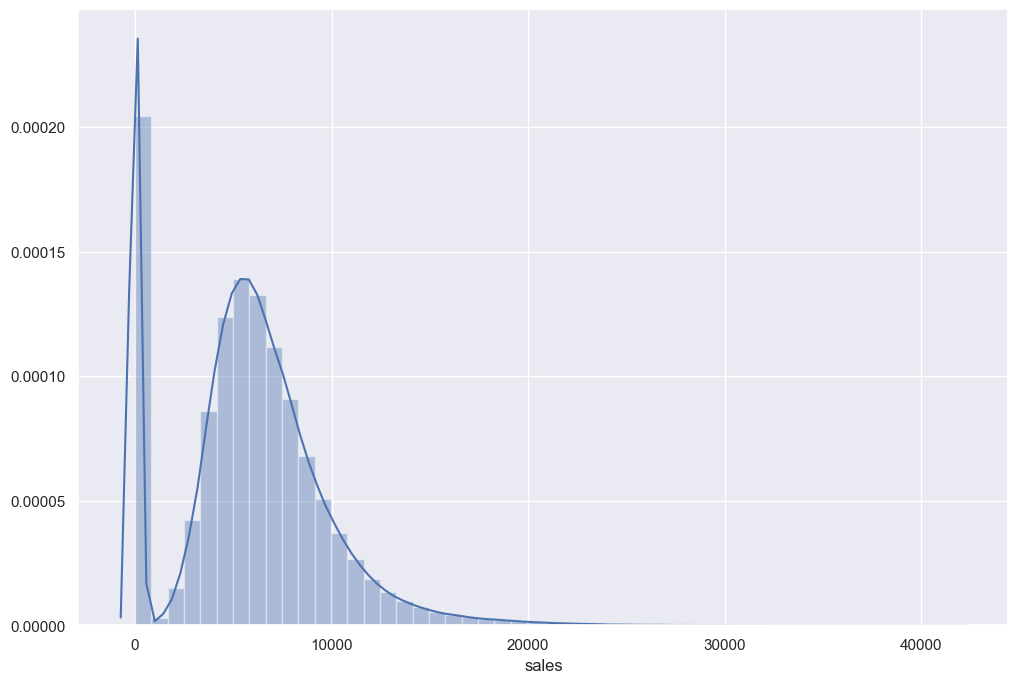

In [19]:
plt.figure(figsize=(12,8))
sns.distplot(df_raw_1['sales'])
plt.show()

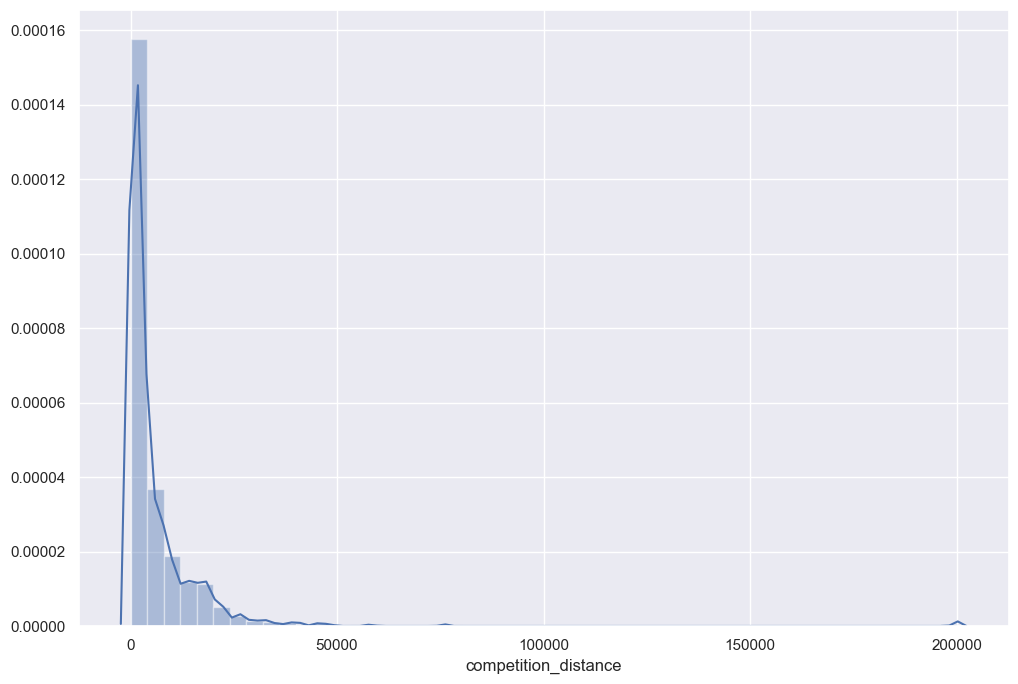

In [20]:
plt.figure(figsize=(12,8))
sns.distplot(df_raw_1['competition_distance'])
plt.show()

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

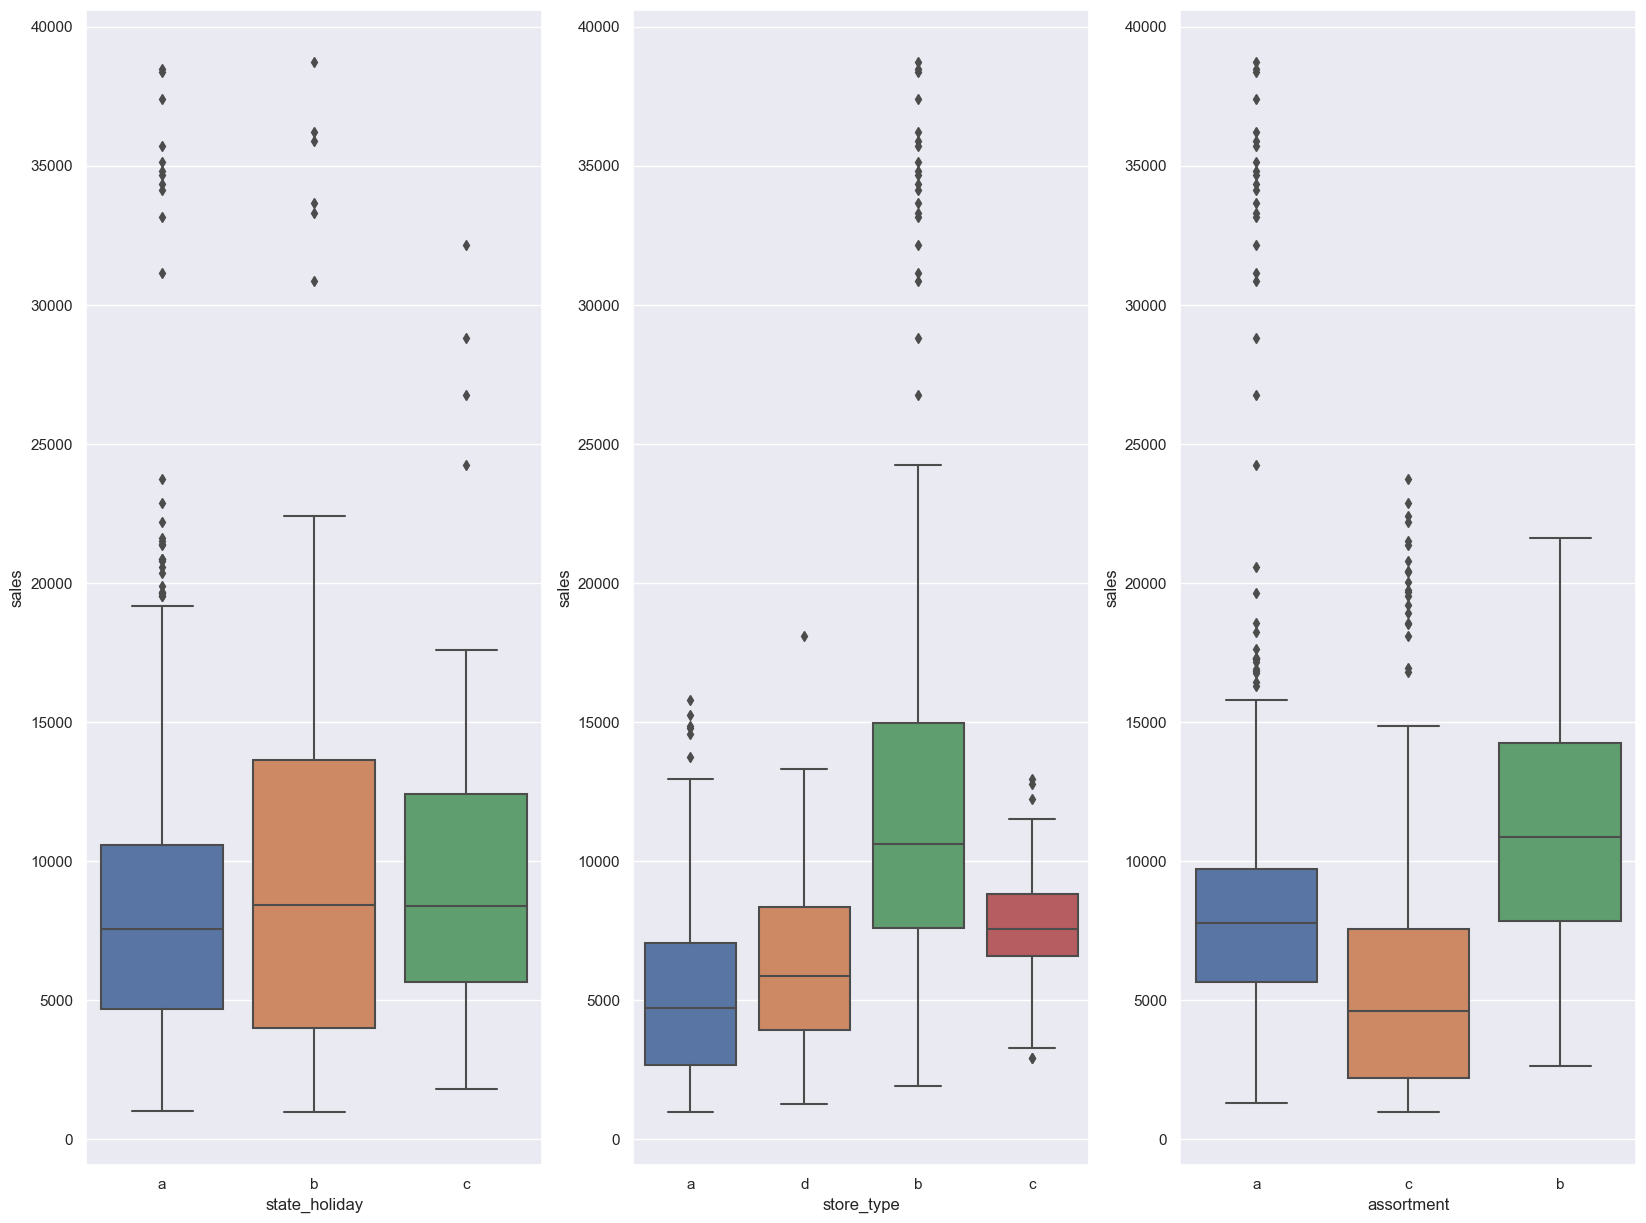

In [22]:
aux1 = df_raw_1[(df_raw_1['state_holiday'] != '0') & (df_raw_1['sales'] > 0)]

plt.figure(figsize=(20,15))

plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y= 'sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y= 'sales', data= aux1)

plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y= 'sales', data= aux1)

plt.show()

# 2.0. Feature Engineering

In [23]:
df2 = df_raw_1.copy()

## 2.1. Hypothesis Mind Map

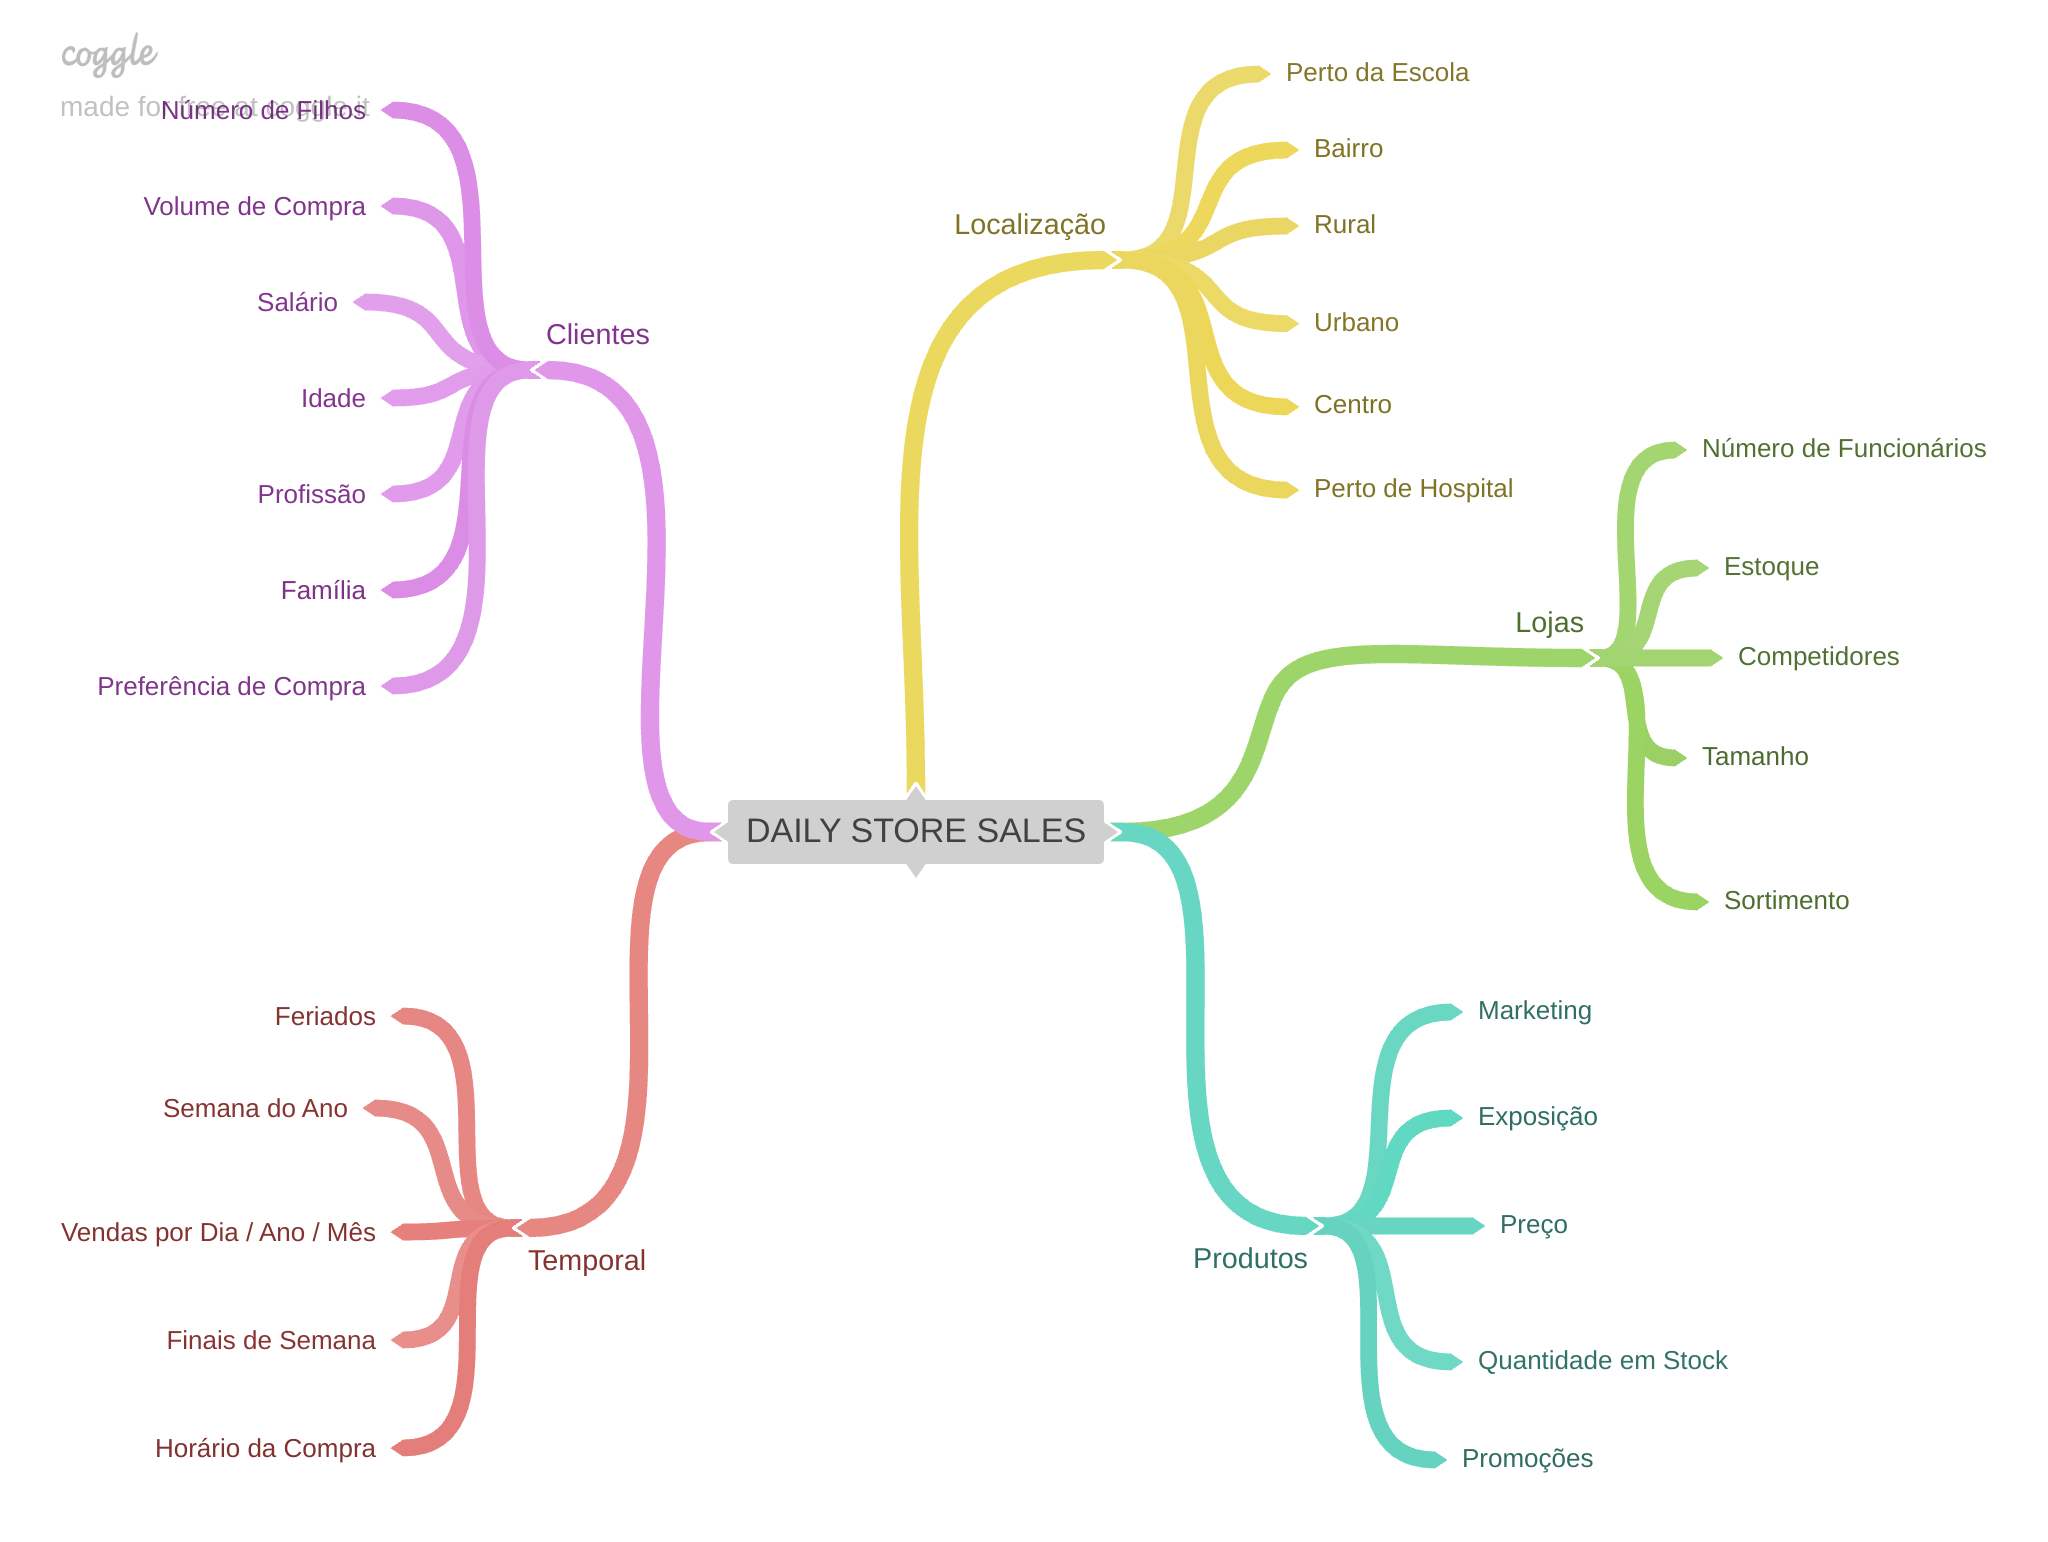

In [24]:
# Fazer o mapa no Coggle e importar com Ipython.core image library
Image('../img/mindmap_hypothesis.png', width= 800, height= 800)

## 2.2. Hypothesis Creation

In [25]:
# Brainstorm reunion or making up by yourself

### 2.2.1 Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.
    
**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.
    
**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Final Hypothesis List

**Selection of highest priority hypothesis**

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature engineering 

In [26]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year - week (mask)
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# versão simplificada do script da aula
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).dt.days

# converte ano-semana da promo em data da promo e calcula a diferença entre a data da promo e a data do registro de venda 
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).dt.days

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [27]:
# versão que eu acho correta usando o módulo da diferença
# (np.abs((df2['date'] - df2['competition_since'])/30)).dt.days 

In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Variable Filtering

## 2.5. Row filtering 

In [29]:
df3 = df2.copy()

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 2.6. Column selection

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Exploratory Data Analysis

In [32]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable (Sales)

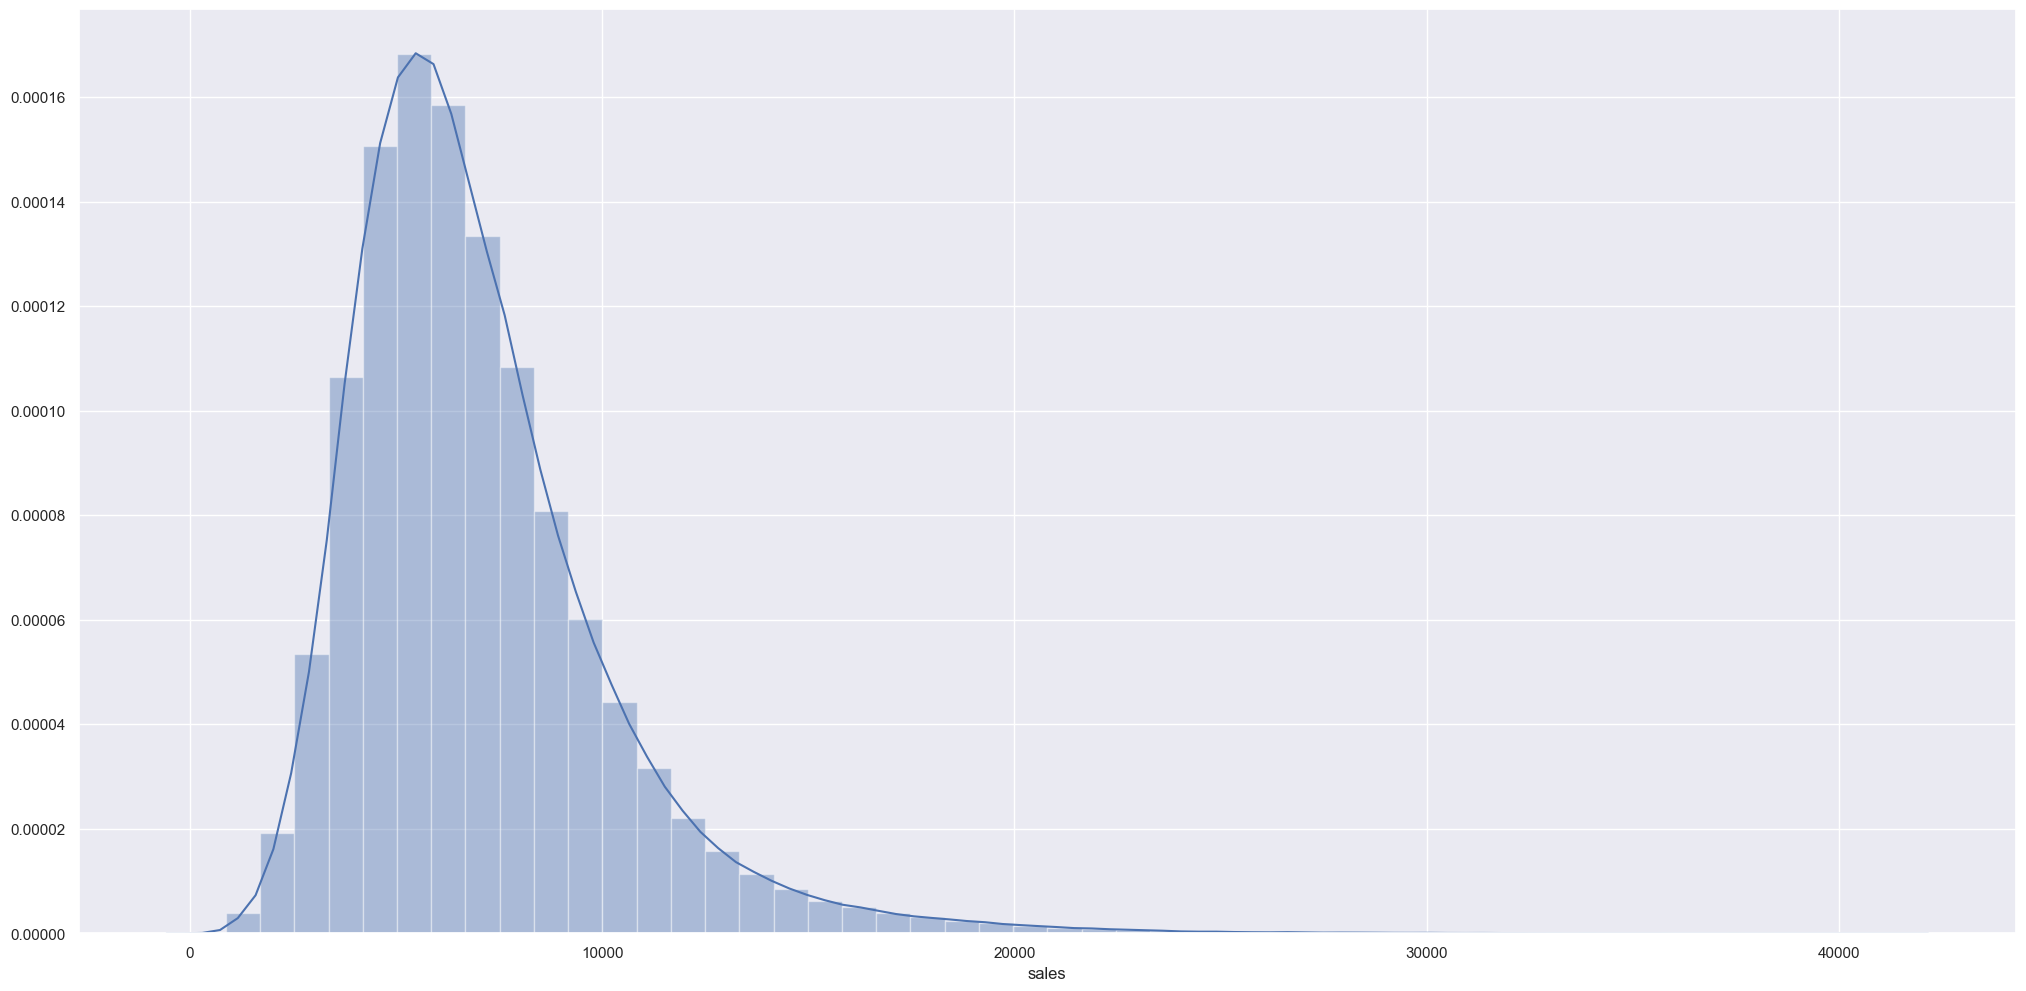

In [33]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variables Histogram (All Numerical features vs Response variable)

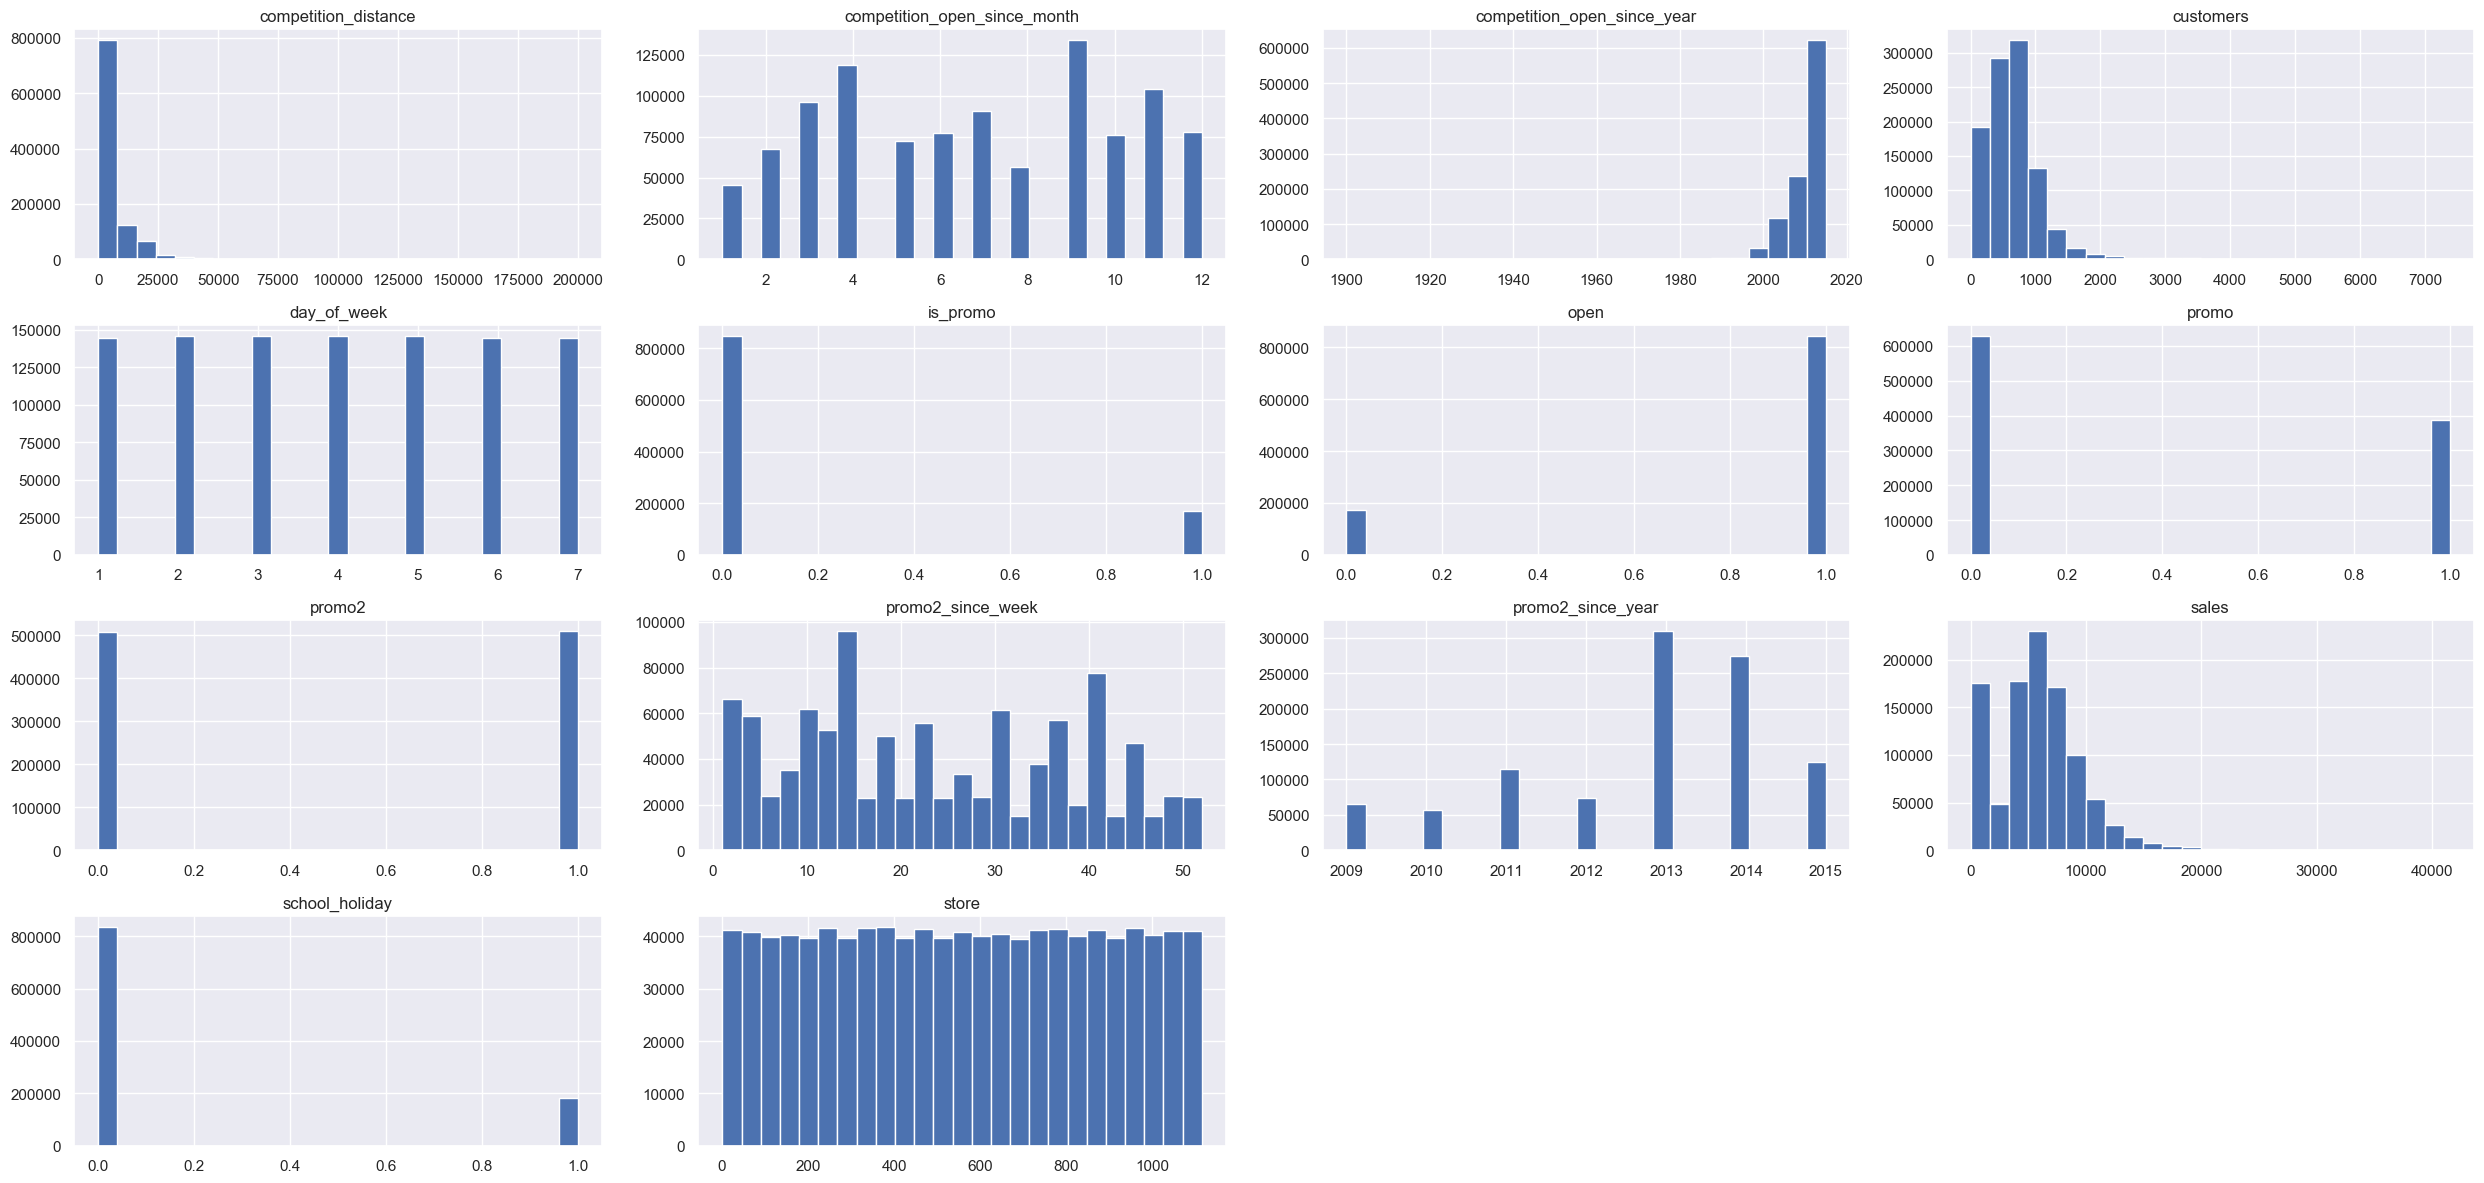

In [34]:
num_attributes.hist(bins=25);
plt.tight_layout()
plt.show()

### 4.1.3 Categorial Variables Histogram

In [35]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

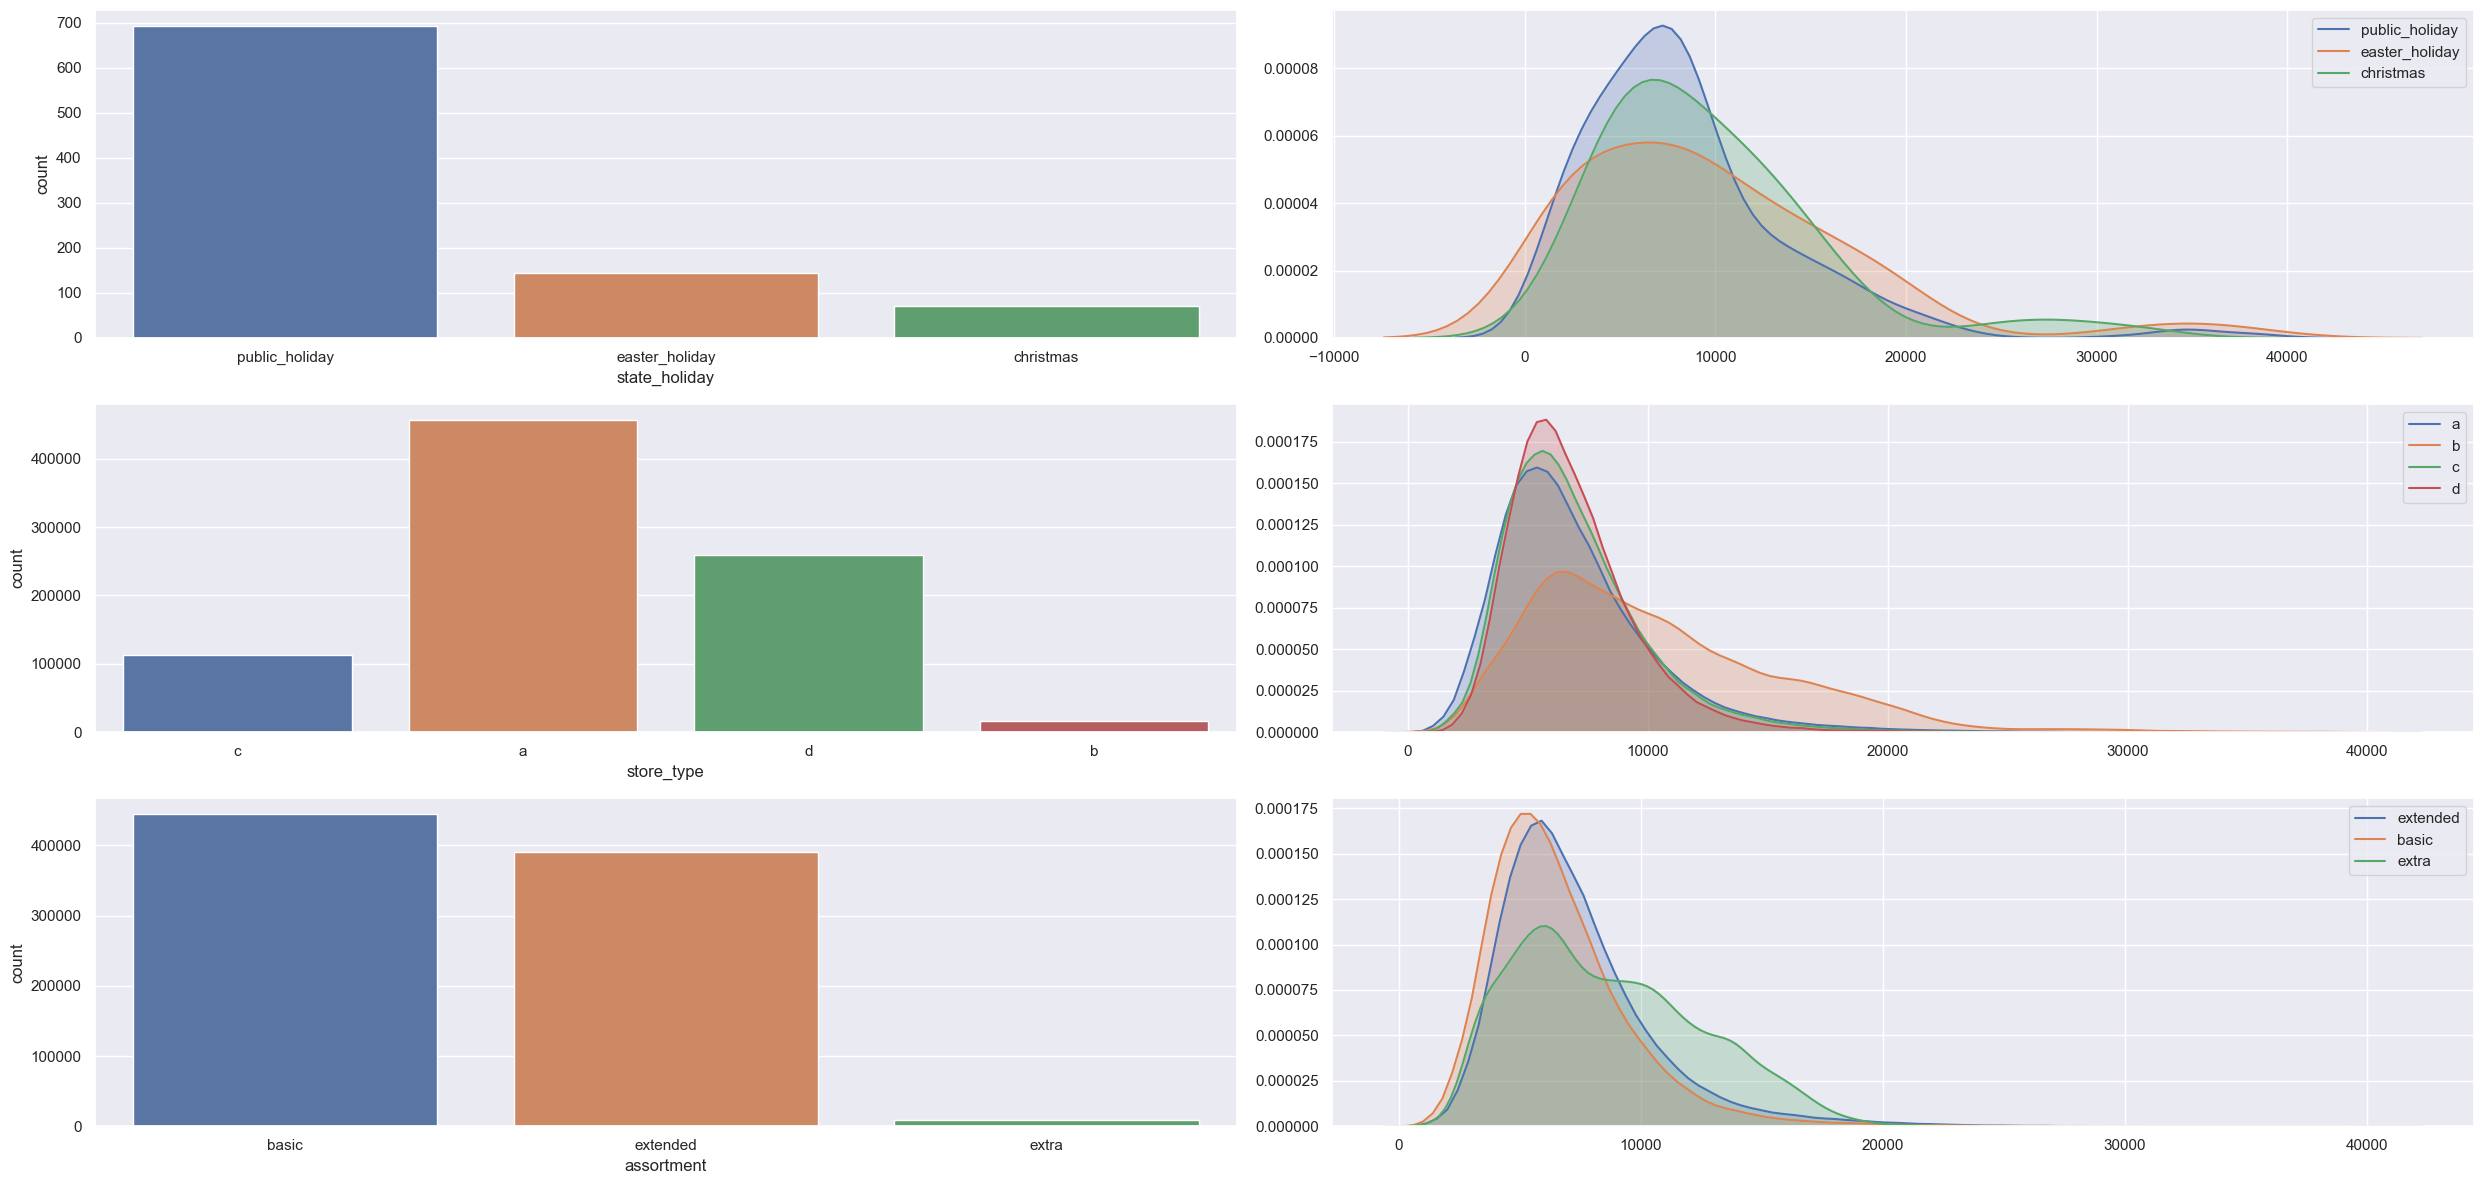

In [36]:
plt.subplot(3,2,1)
cutted = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(cutted['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df3[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df3[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

plt.tight_layout()


## 4.2. Bivariate Analysis (Hypothesis Validation)

#### **H1. Lojas com maior sortimentos deveriam vender mais.**

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

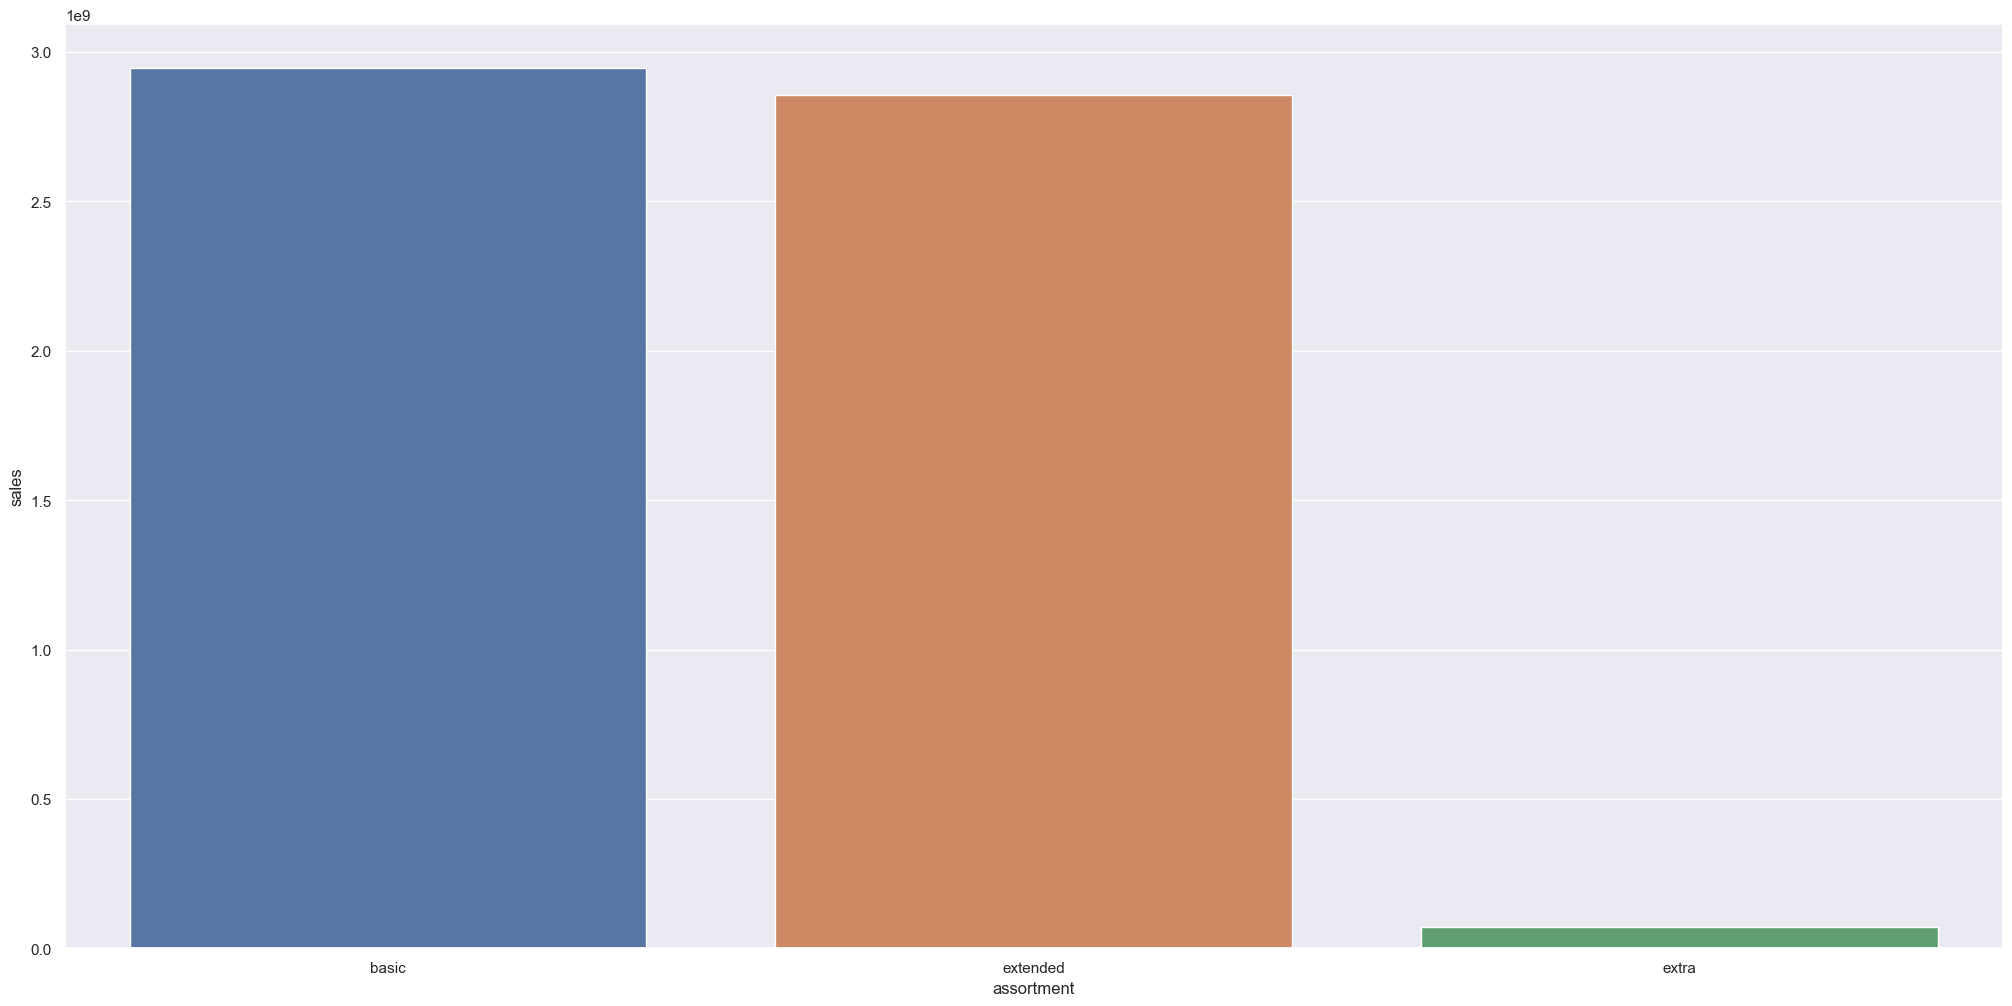

In [37]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

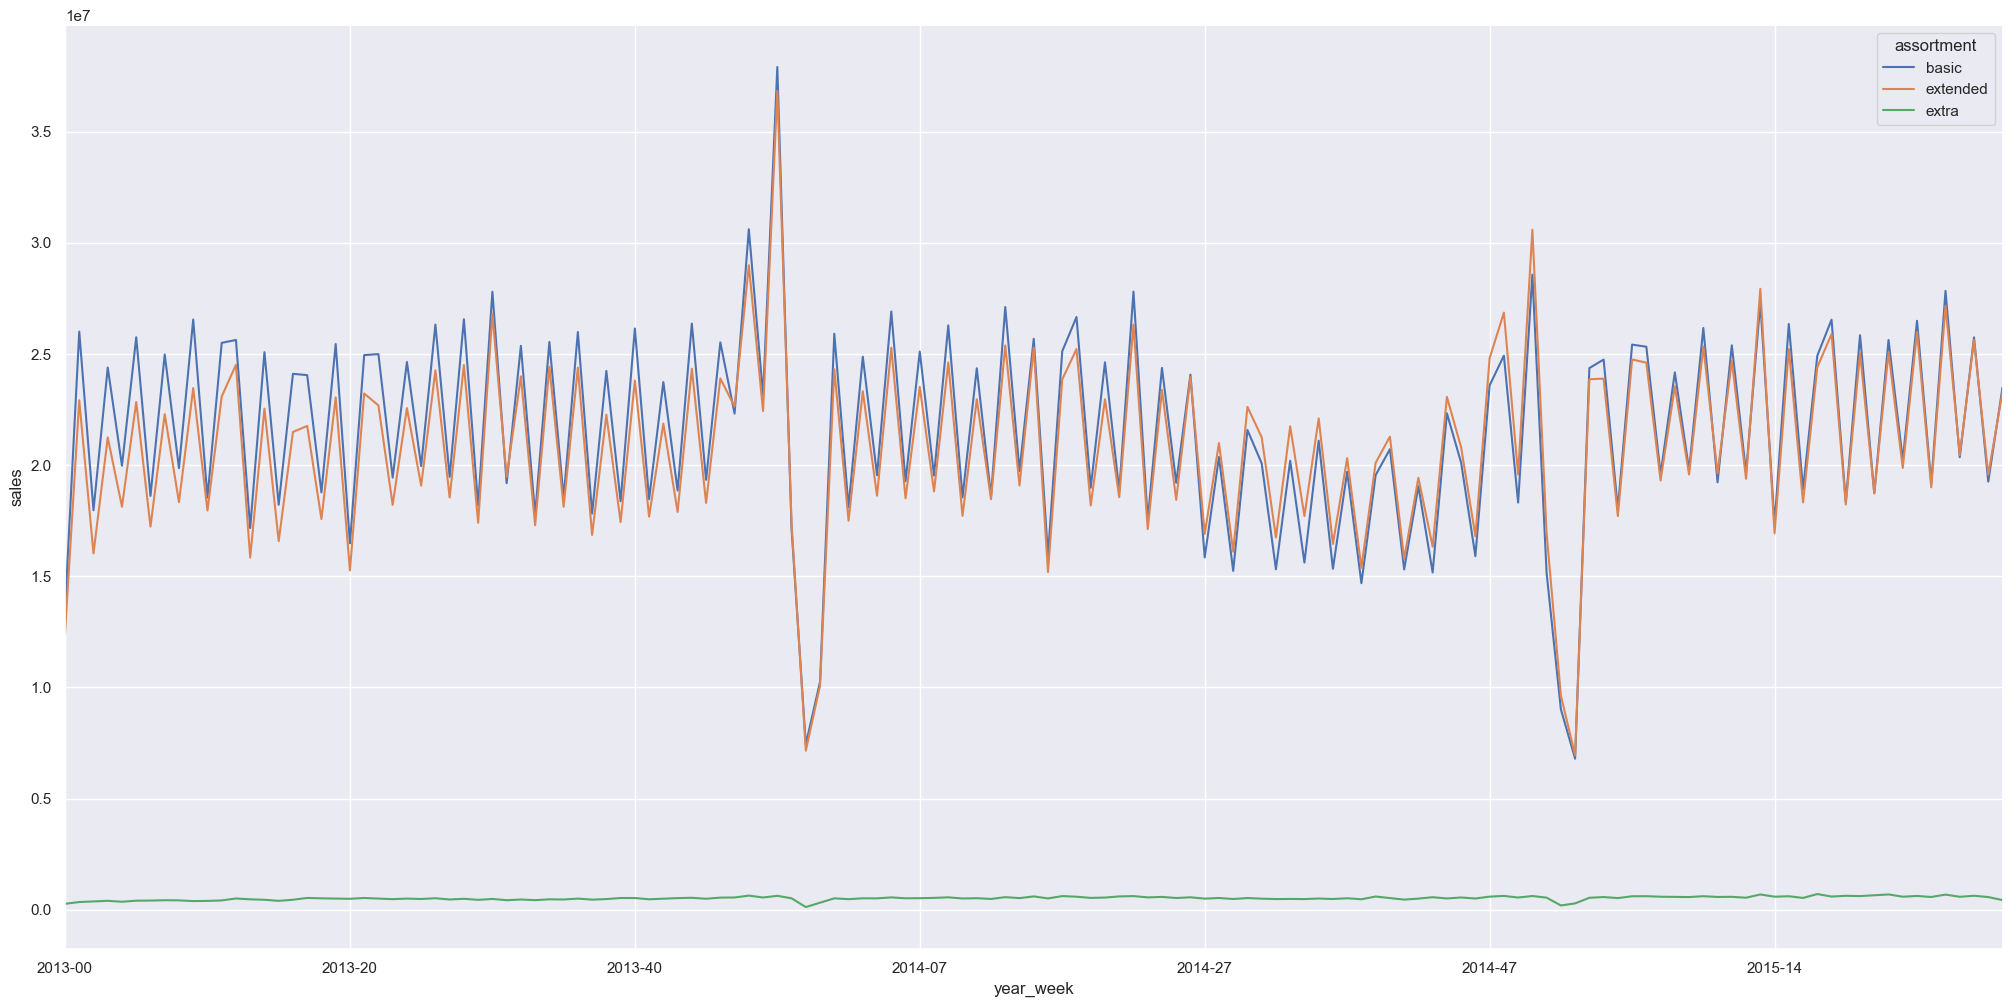

In [38]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();
plt.ylabel('sales');

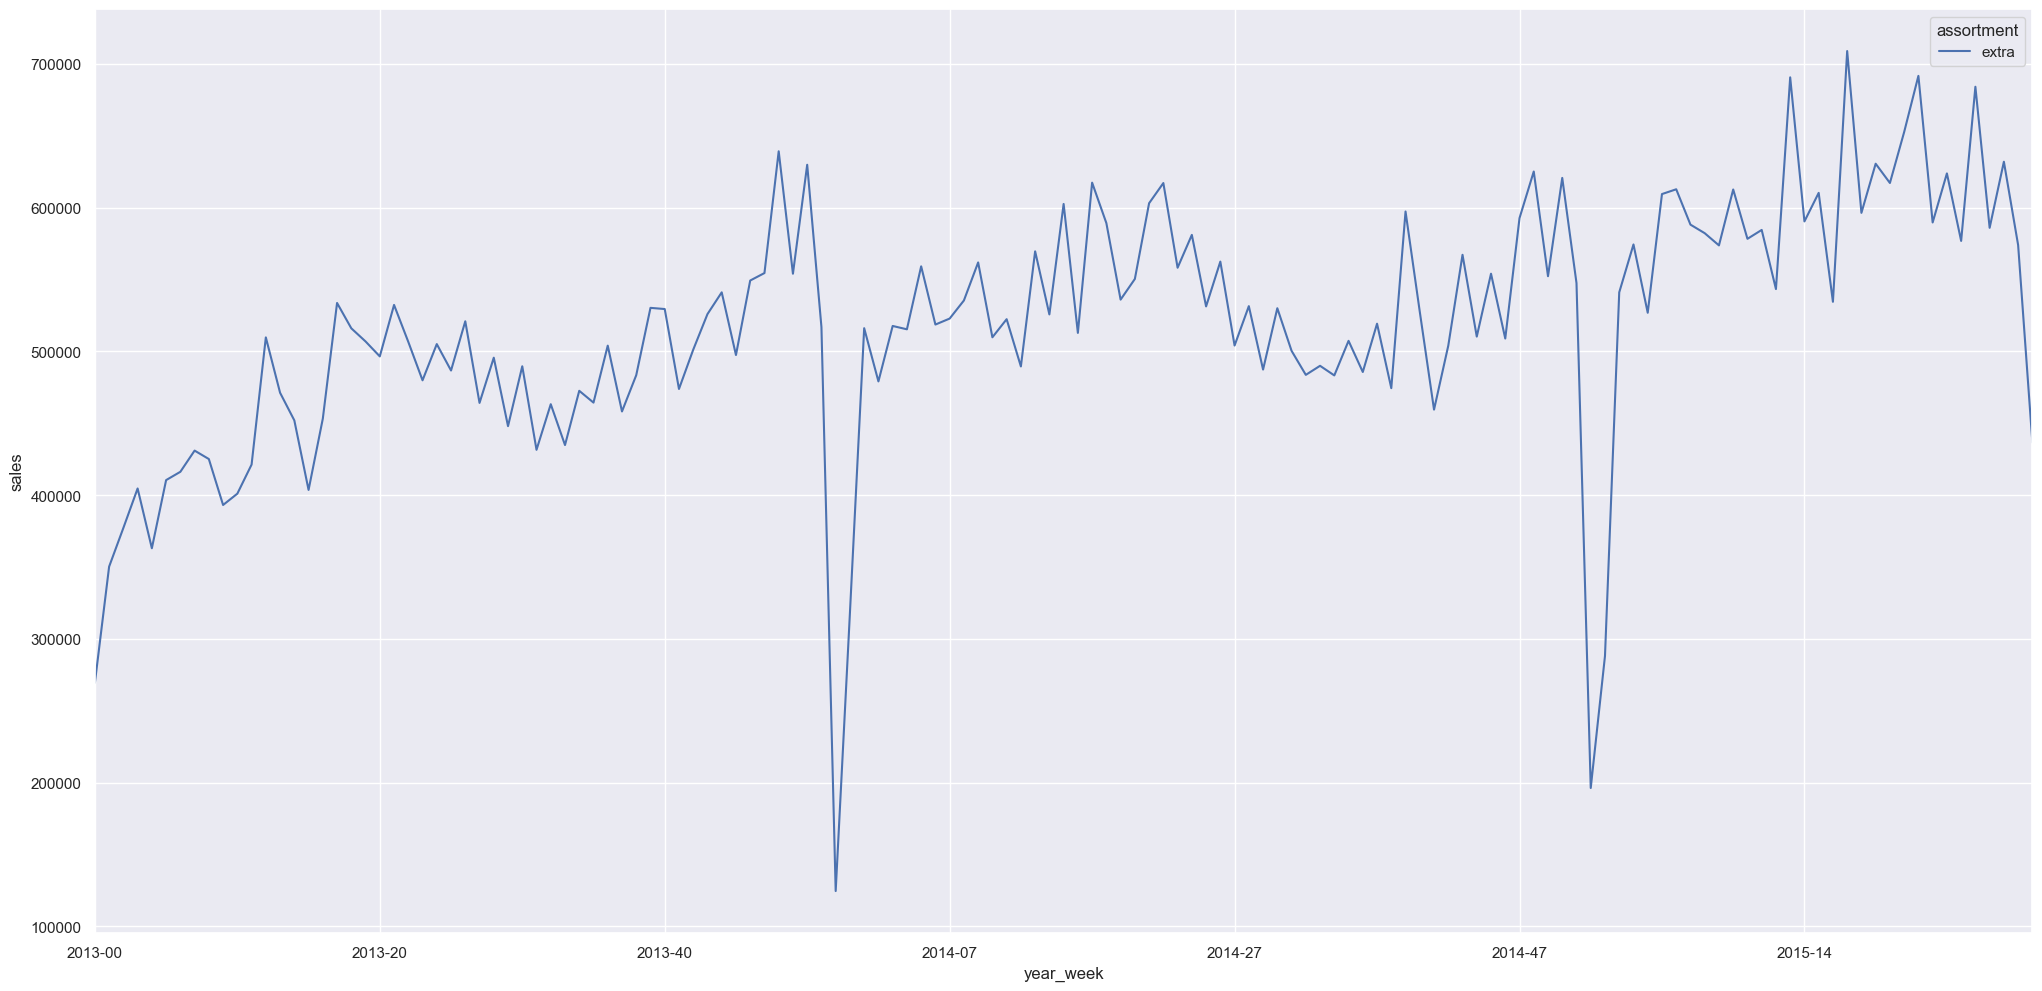

In [39]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()
plt.ylabel('sales');

#### **H2. Lojas com competidores mais próximos deveriam vender menos.**

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

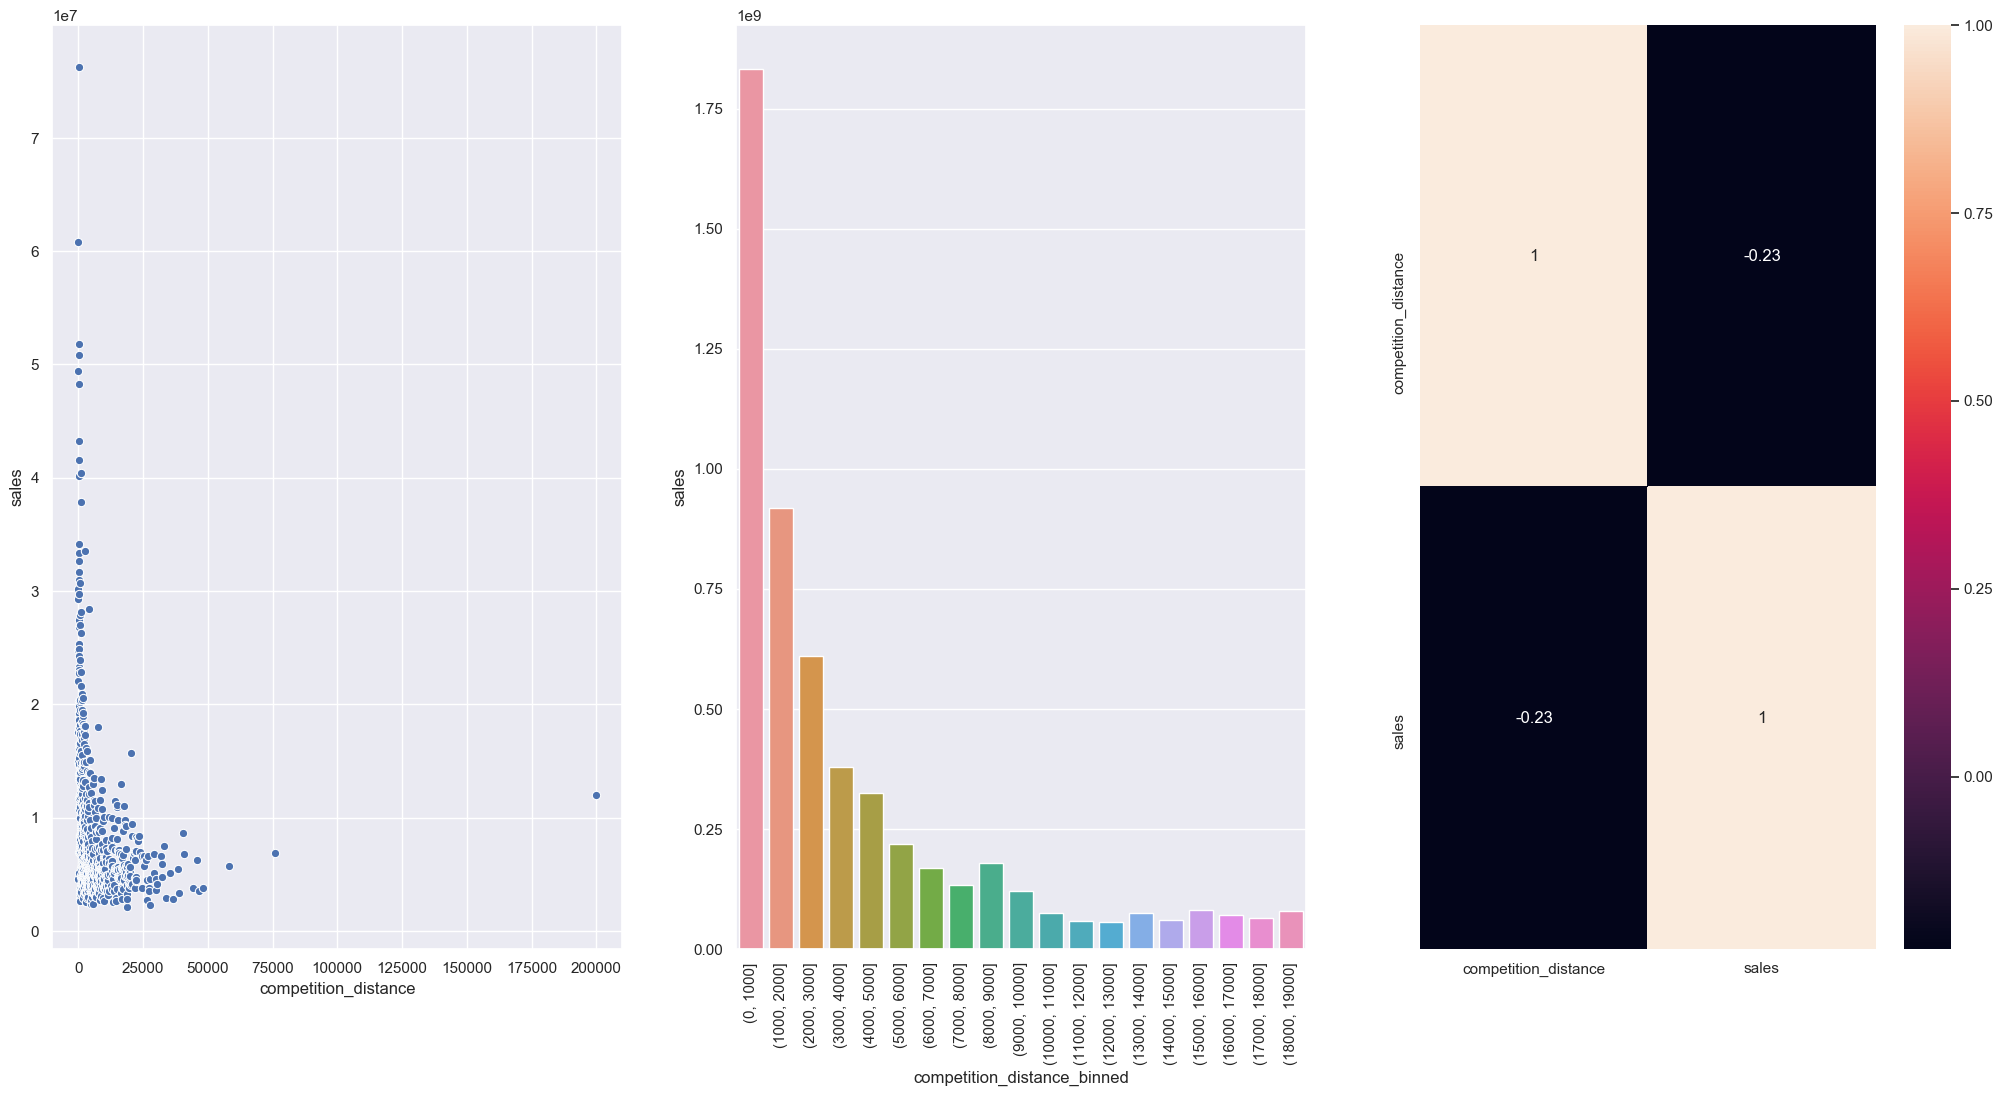

In [40]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


#### **H3. Lojas com competidores à mais tempo deveriam vendem mais.**

**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

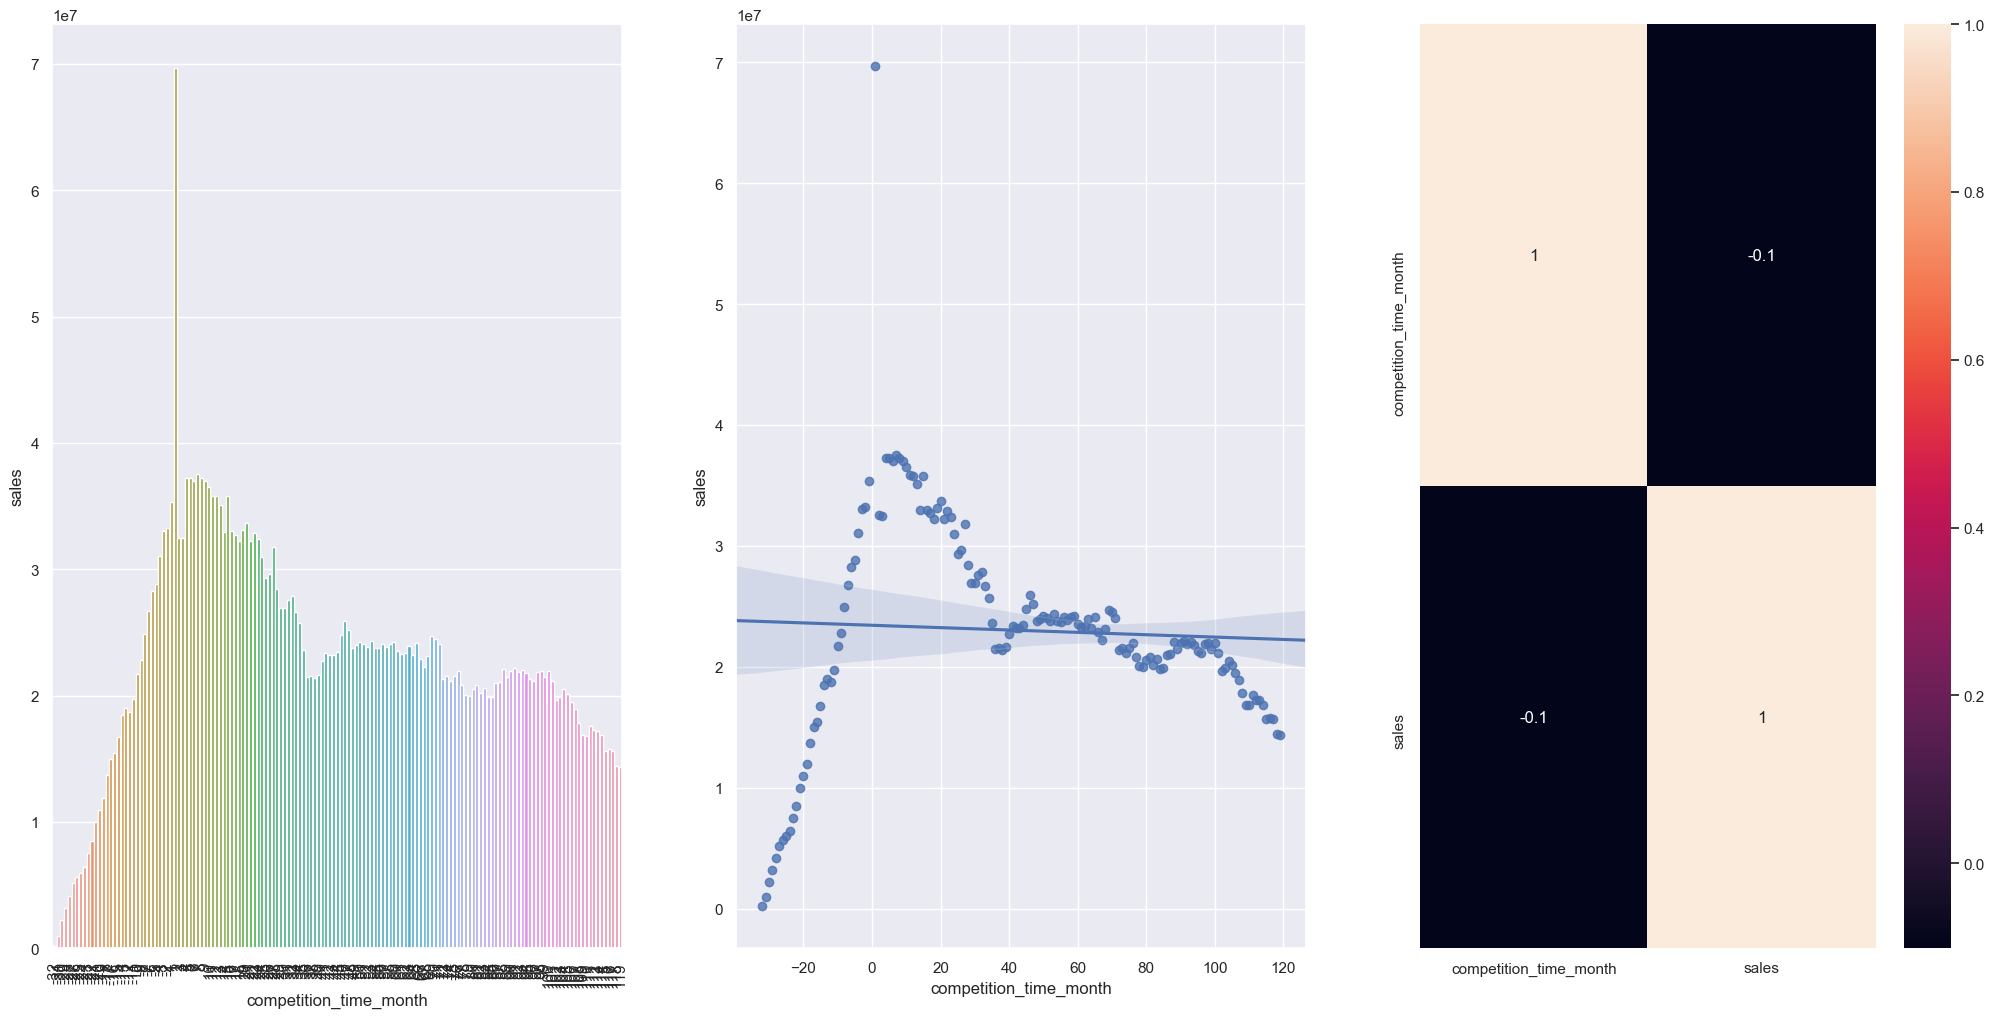

In [41]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**

FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

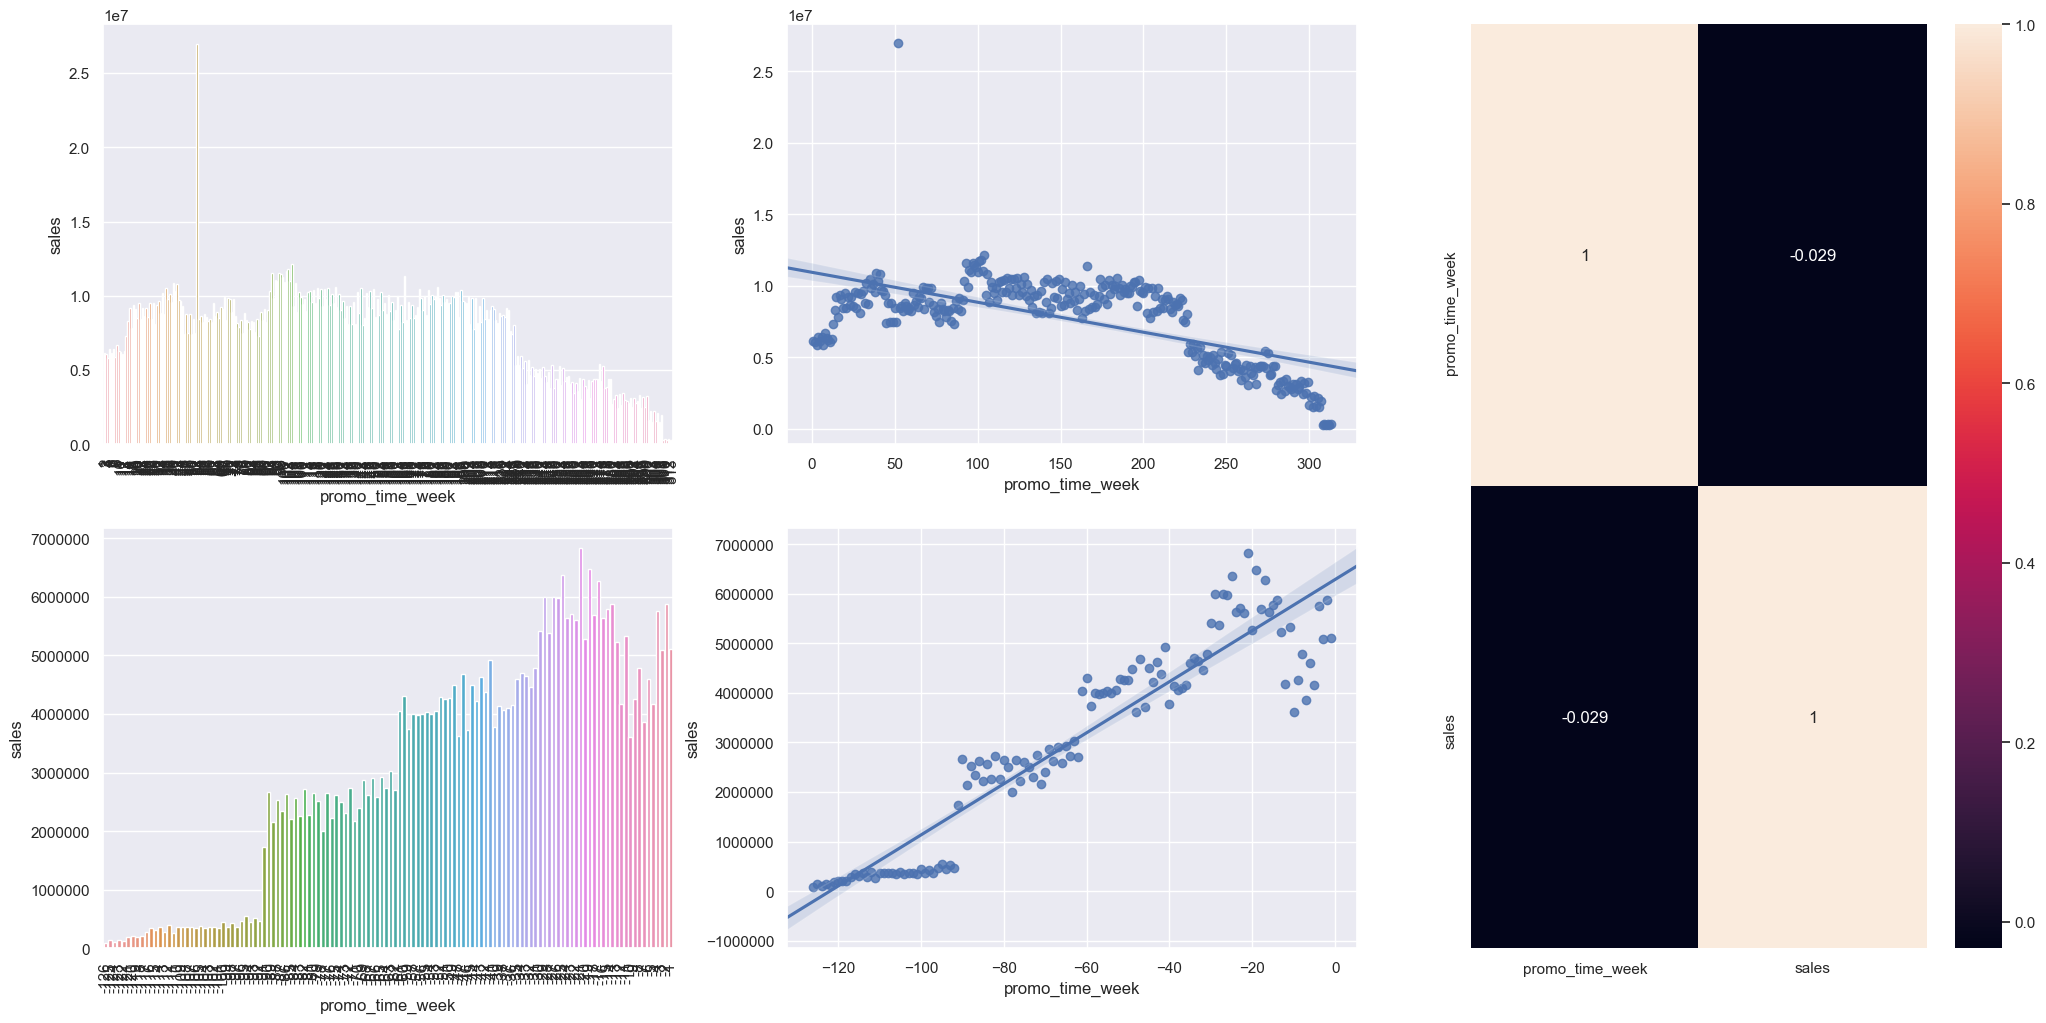

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H5. Lojas com mais dias de promoção deveriam vender mais.**

#### **H6. Lojas com mais promoções consecutivas deveriam vender mais.**

FALSA Lojas com mais promocoes consecutivas vendem menos

In [43]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


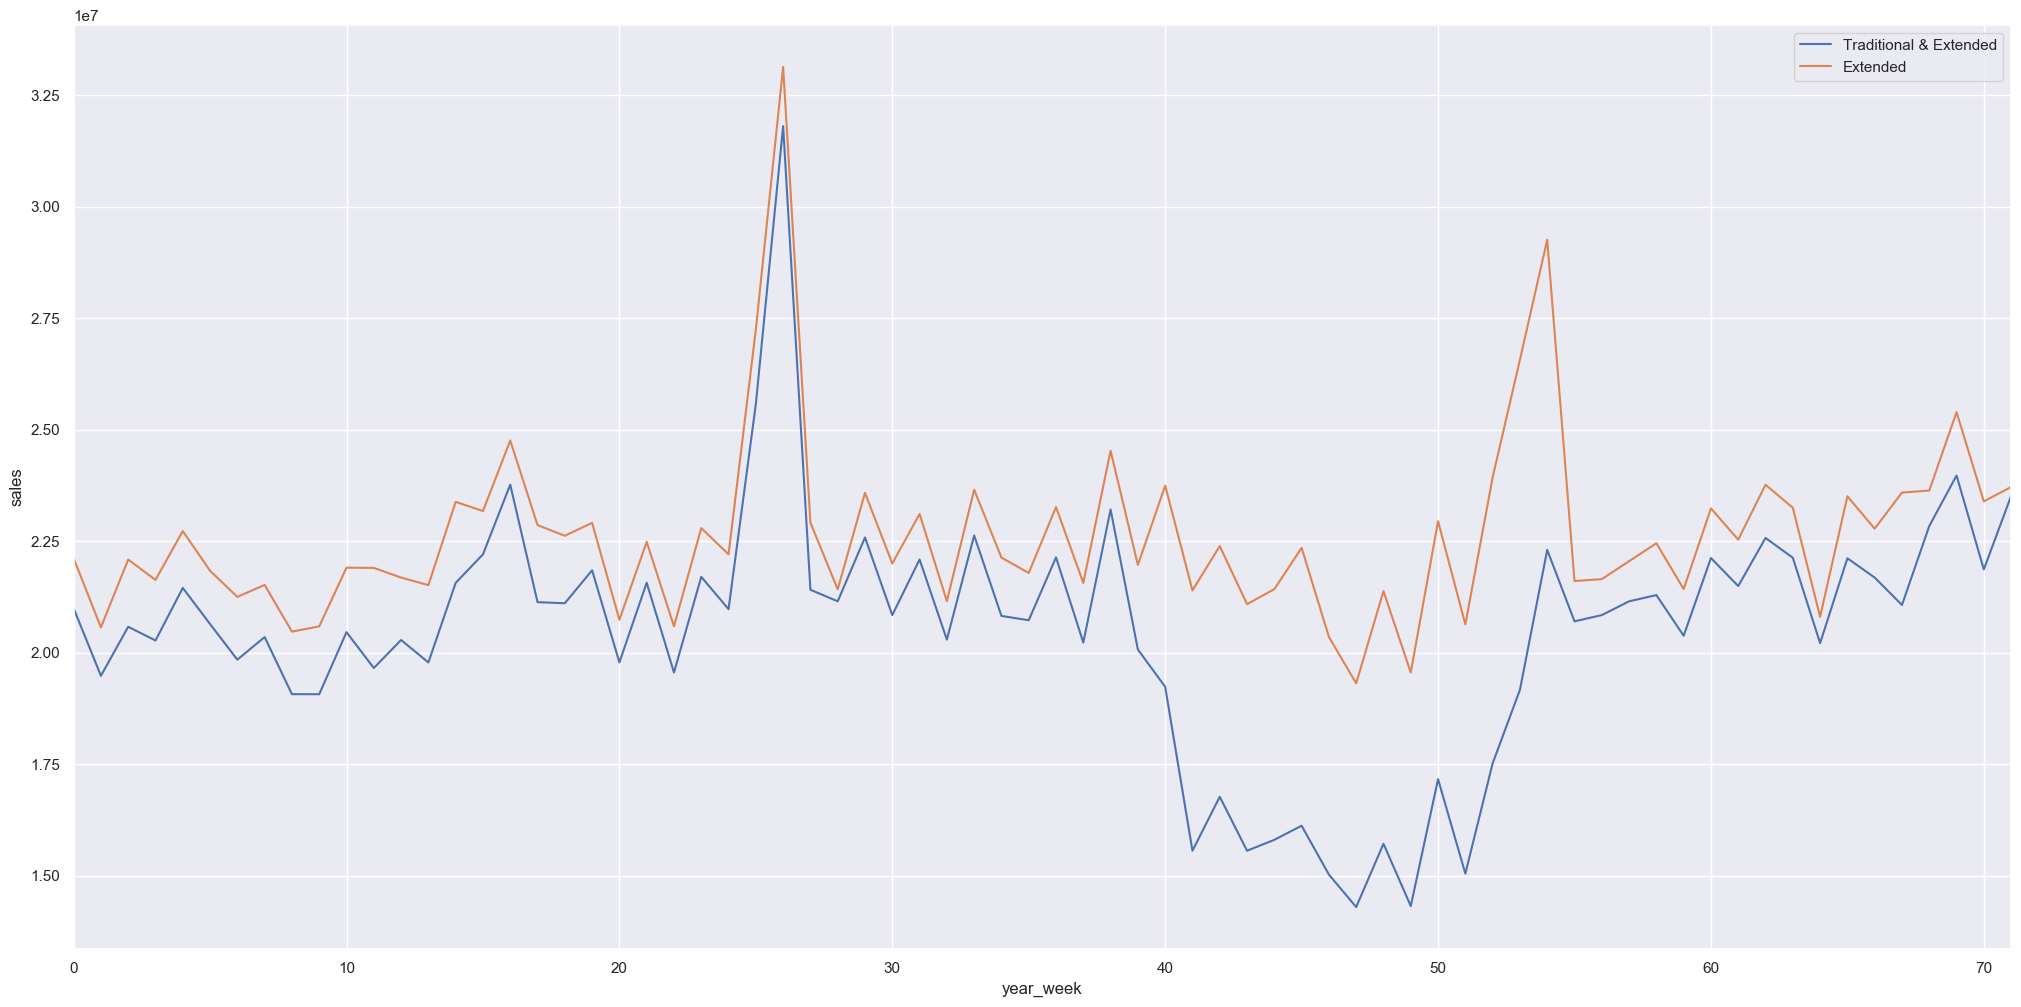

In [44]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Traditional & Extended', 'Extended']);
plt.xlabel('year_week');
plt.ylabel('sales');

#### **H7. Lojas abertas durante o feriado de Natal deveriam vender mais.**

FALSA Lojas abertas durante o feriado do Natal vendem menos

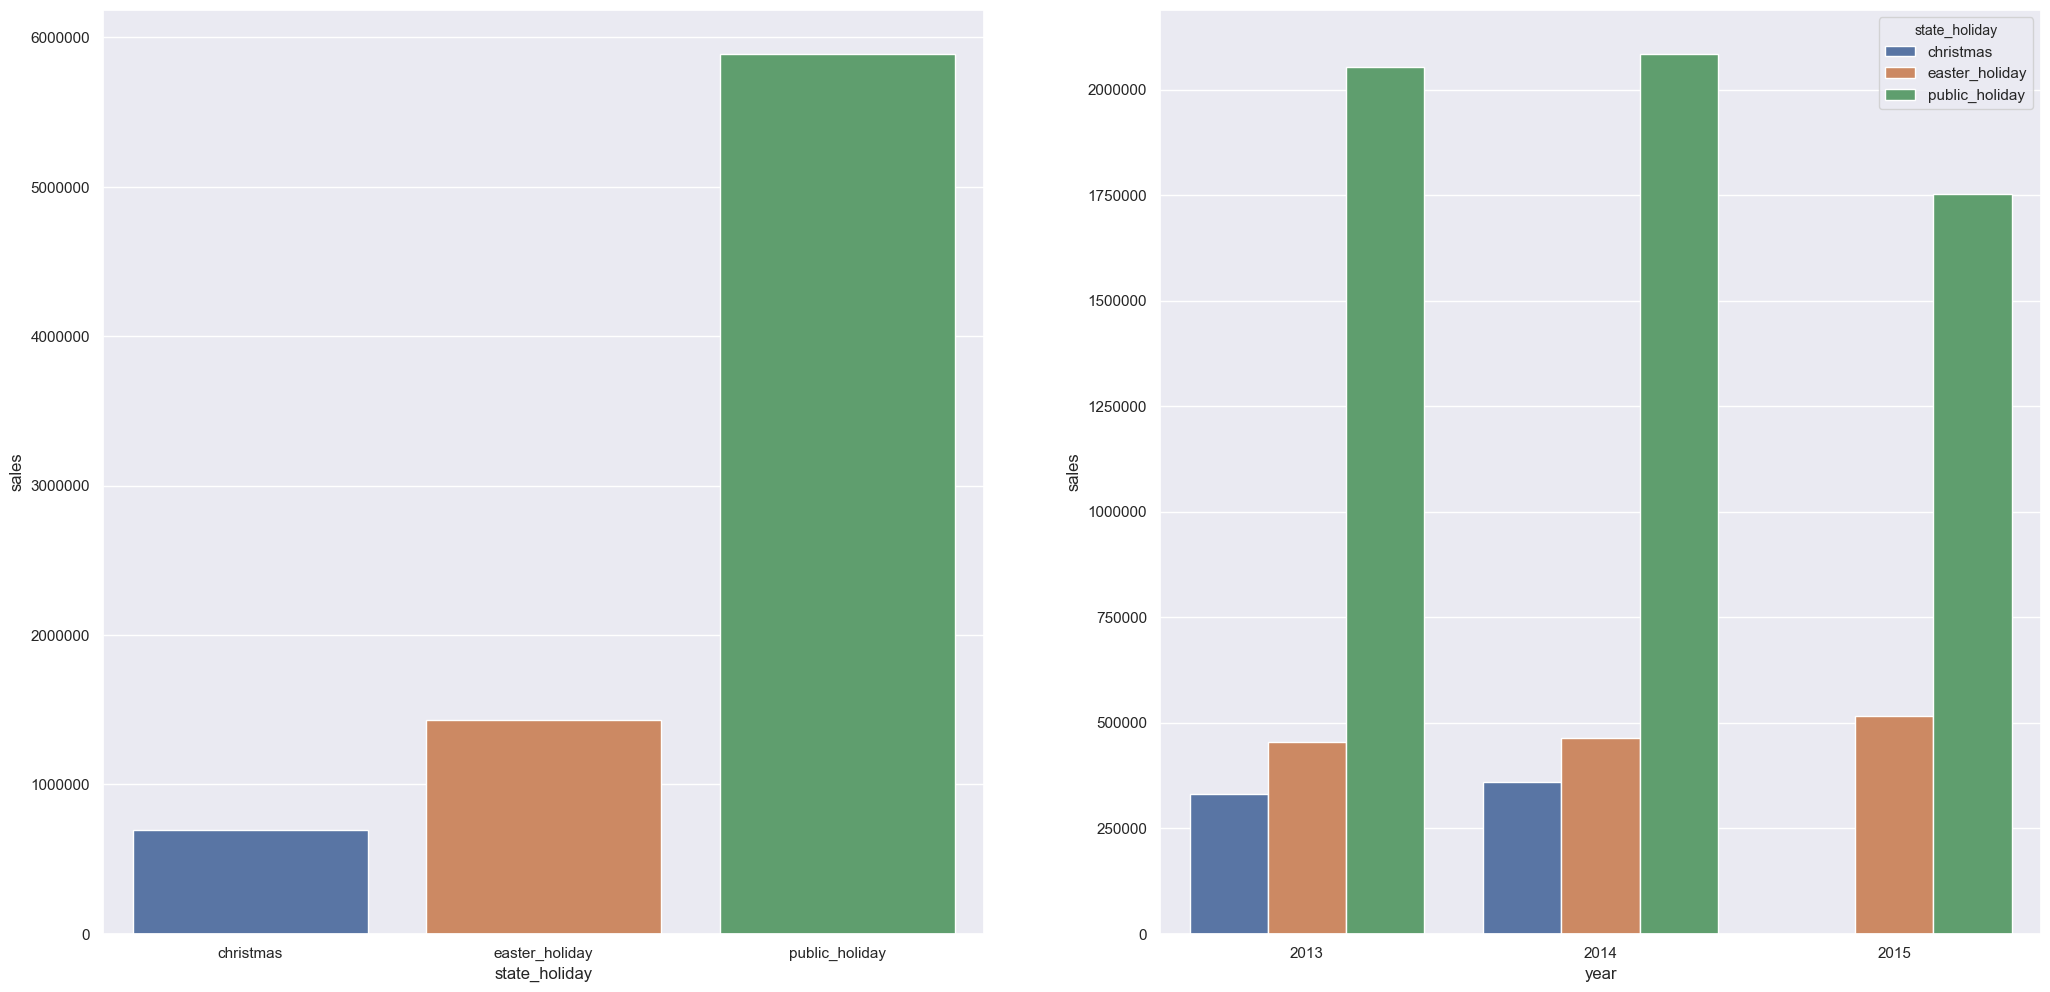

In [45]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### **H8. Lojas deveriam vender mais ao longo dos anos.**

FALSA Lojas vendem menos ao longo dos anos

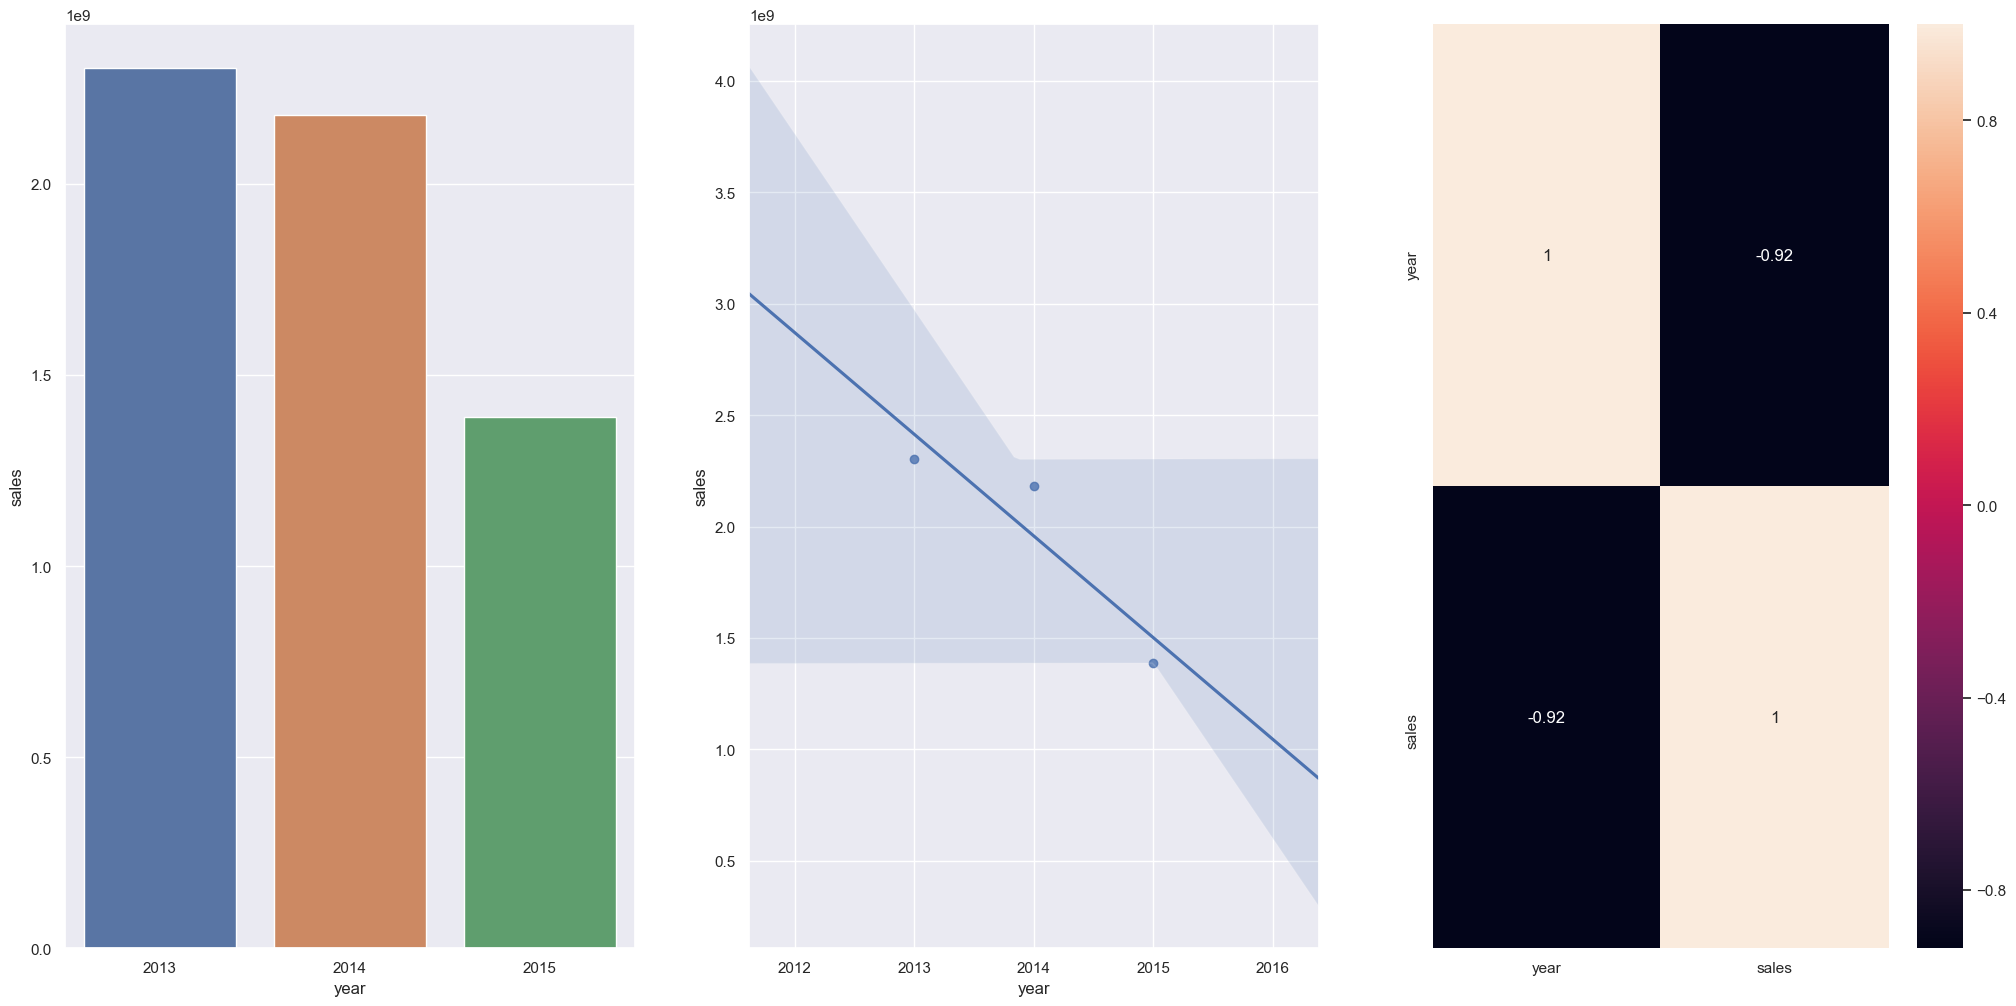

In [46]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H9. Lojas deveriam vender mais no segundo semestre do ano.**

FALSA Lojas vendem menos no segundo semestre do ano

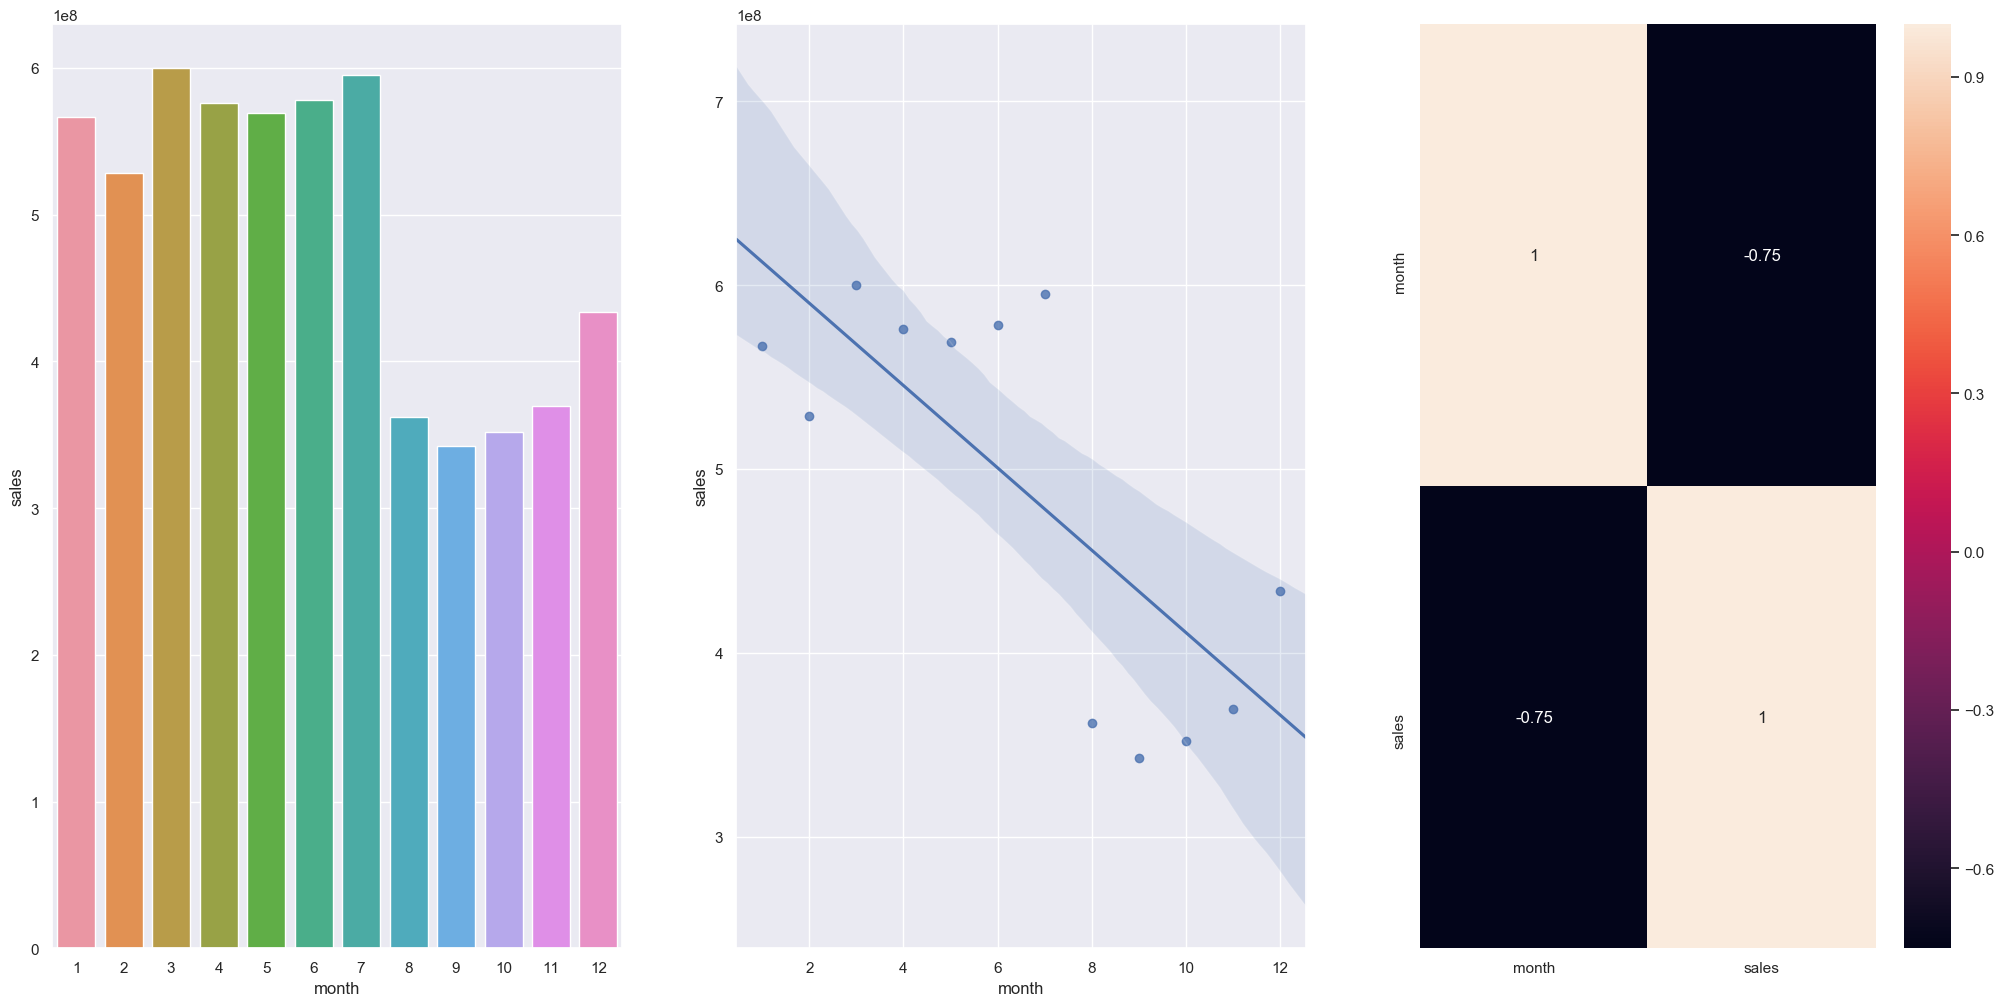

In [47]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H10. Lojas deveriam vender mais depois do dia 10 de cada mês.**

VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.

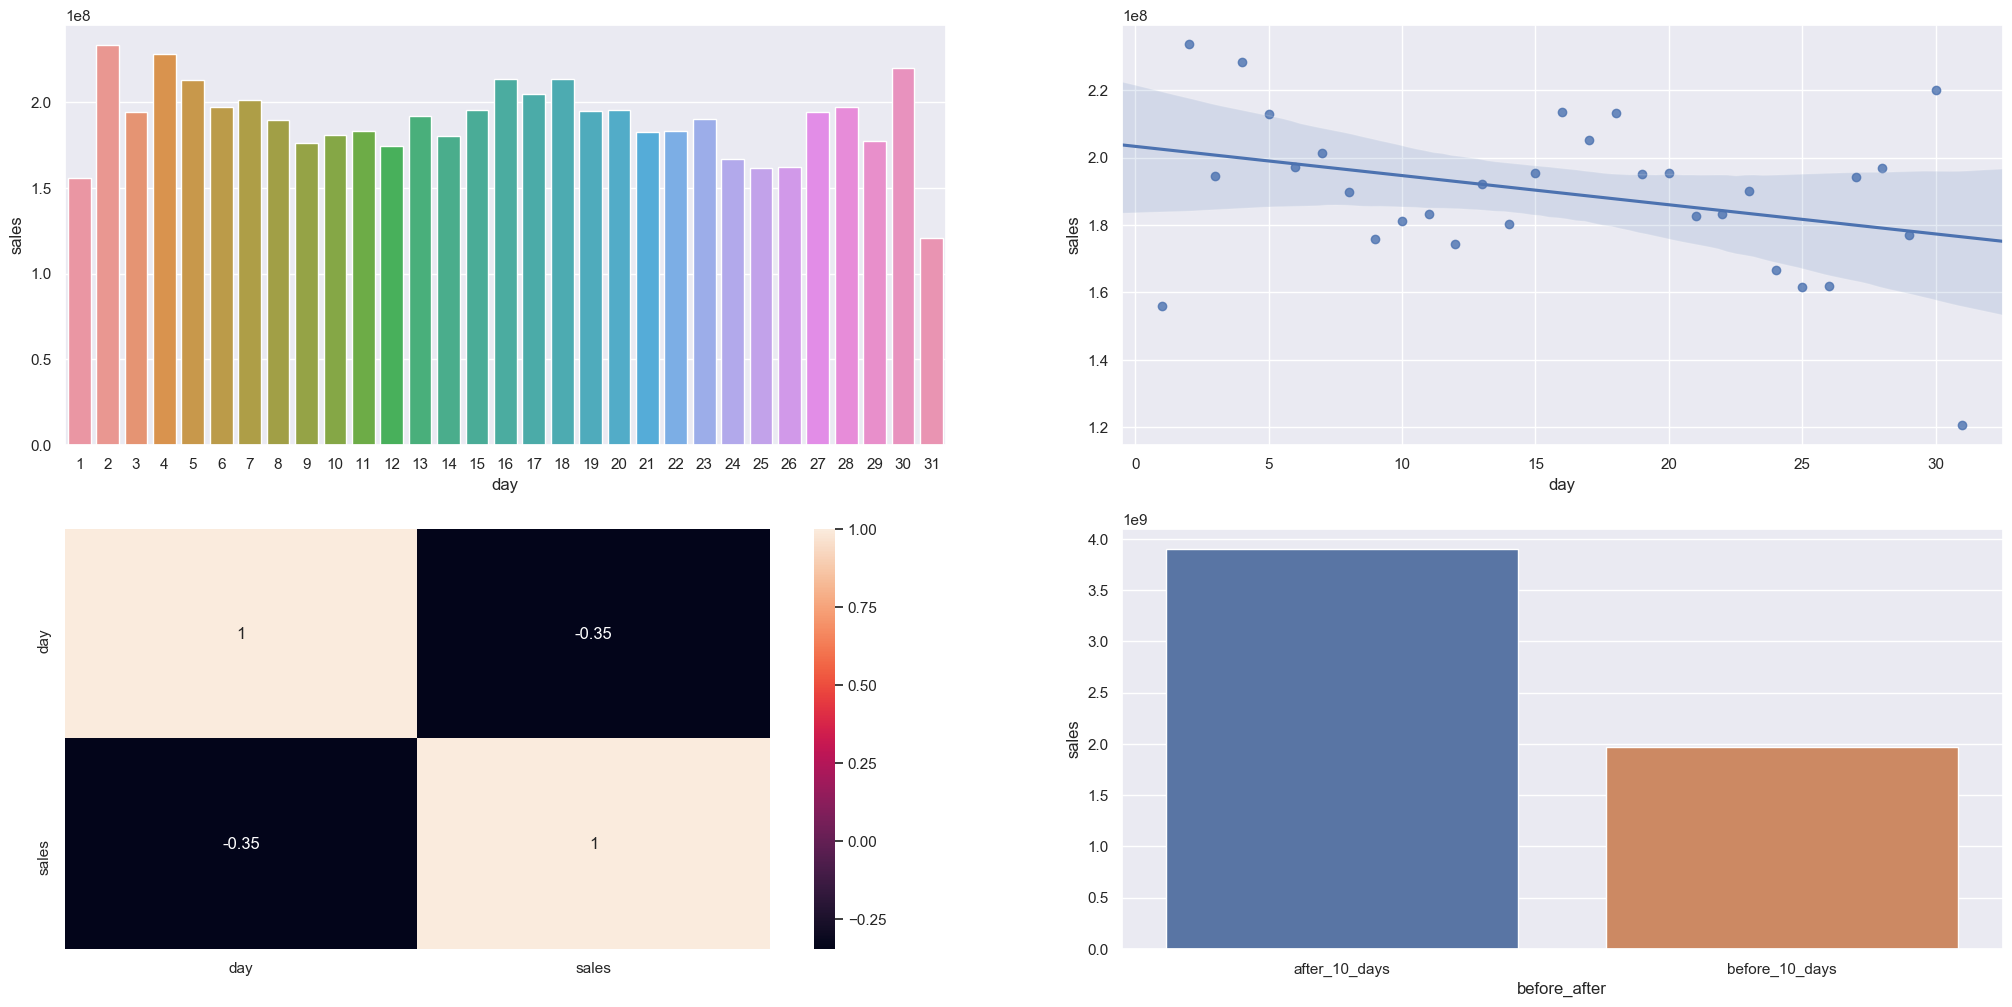

In [48]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );


#### **H11. Lojas deveriam vender menos aos finais de semana.**

VERDADEIRA Lojas vendem menos nos final de semana.

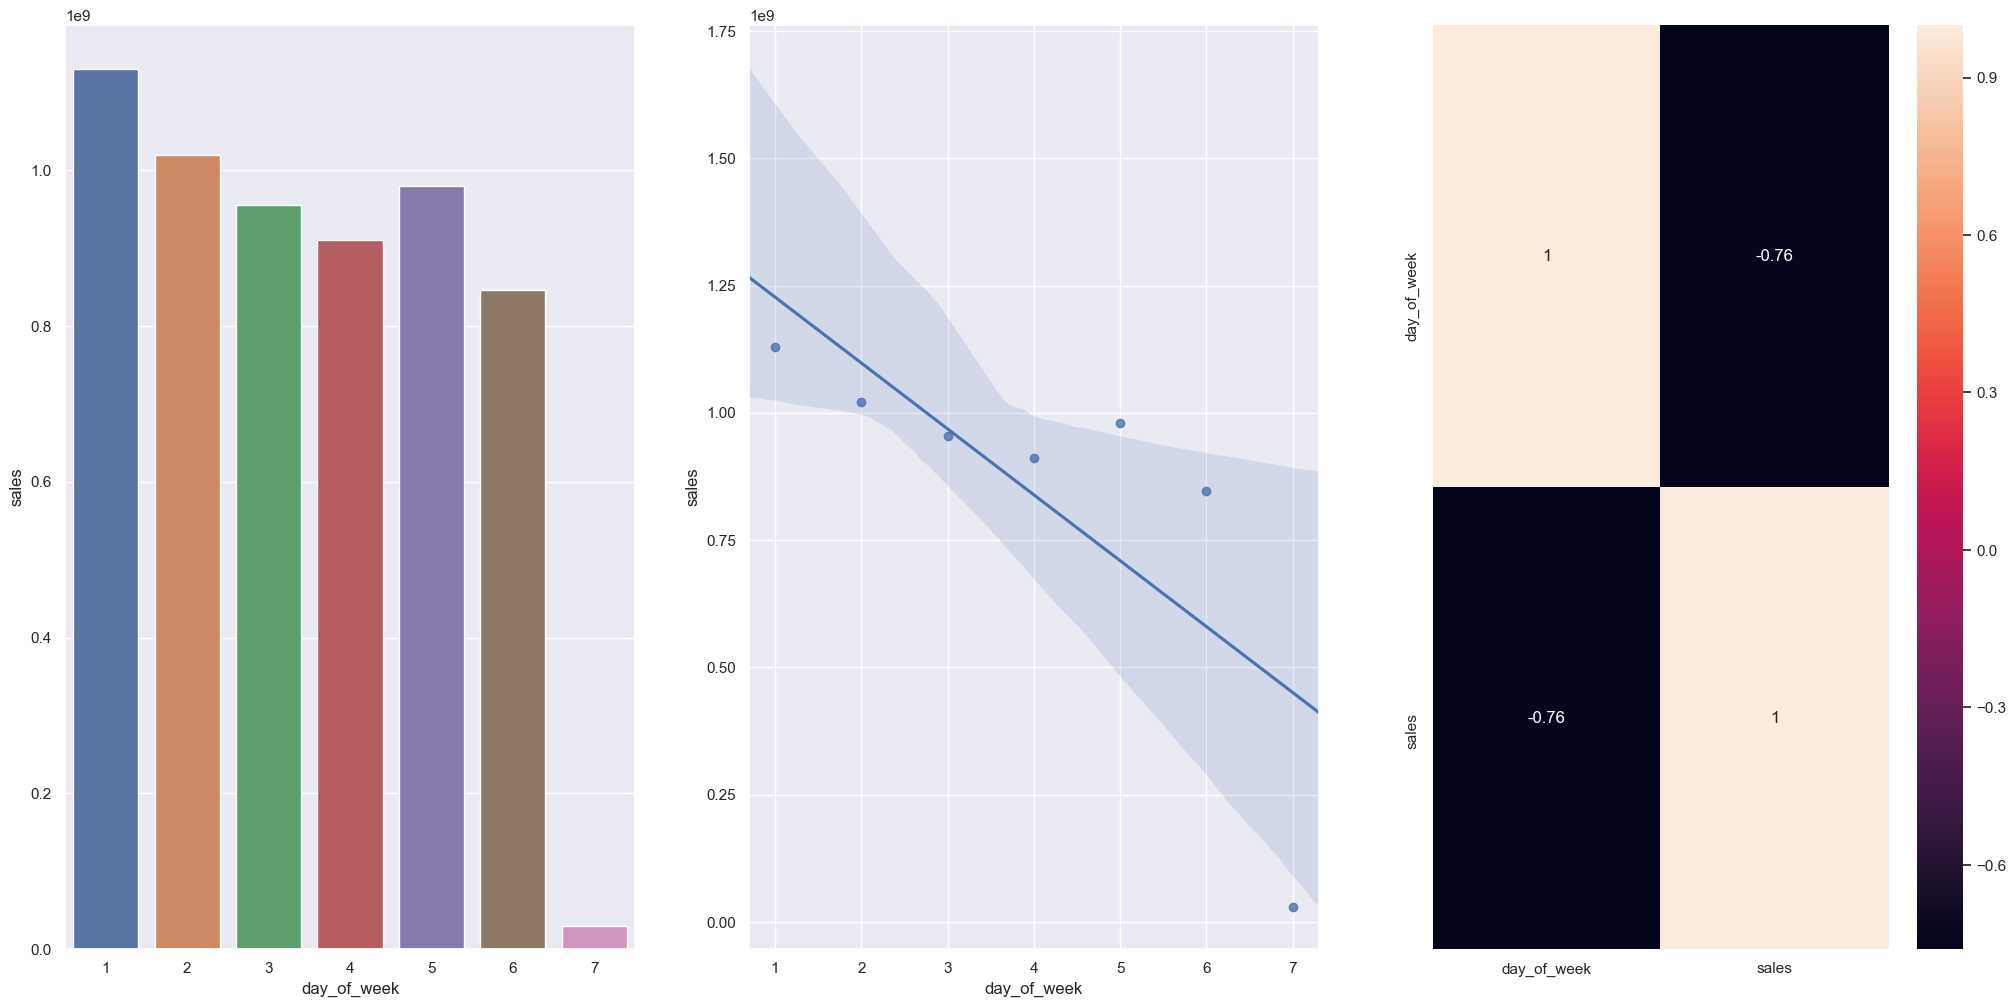

In [49]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H12. Lojas deveriam vender menos durante os feriados escolares.**

VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto. 

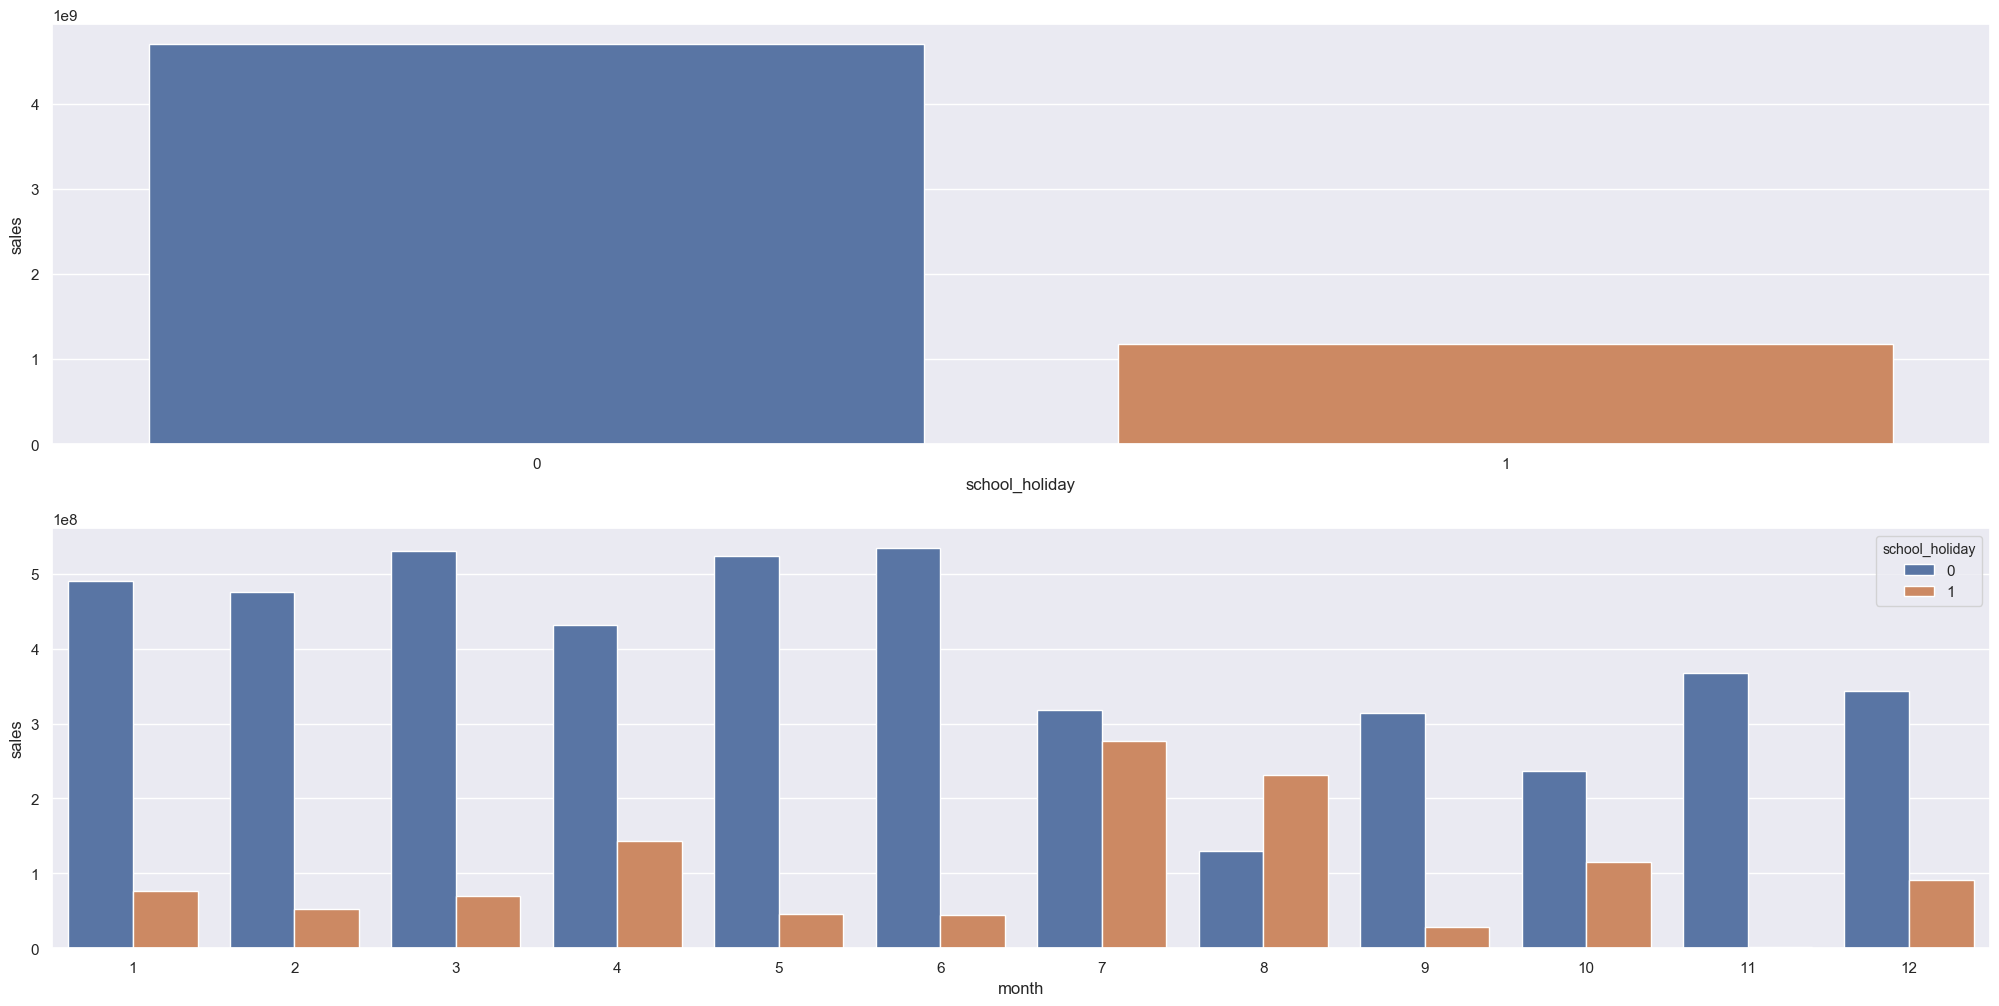

In [50]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


#### 4.3.1 Hypothesis validation summary 

In [51]:
tab = [['Hypothesis', 'Conclusion', 'Relevancy'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H7', 'Falsa', 'Baixa'],
    ['H8', 'Falsa', 'Media'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Falsa', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Alta'],
    ['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevancy
------------  ------------  -----------
H1            Falsa         Baixa
H2            Falsa         Media
H3            Falsa         Media
H4            Falsa         Baixa
H5            -             -
H7            Falsa         Baixa
H8            Falsa         Media
H9            Falsa         Alta
H10           Falsa         Alta
H11           Verdadeira    Alta
H12           Verdadeira    Alta
H13           Verdadeira    Baixa


## 4.3. Multivariate Analysis

### 4.3.1 Numerical columns

In [52]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


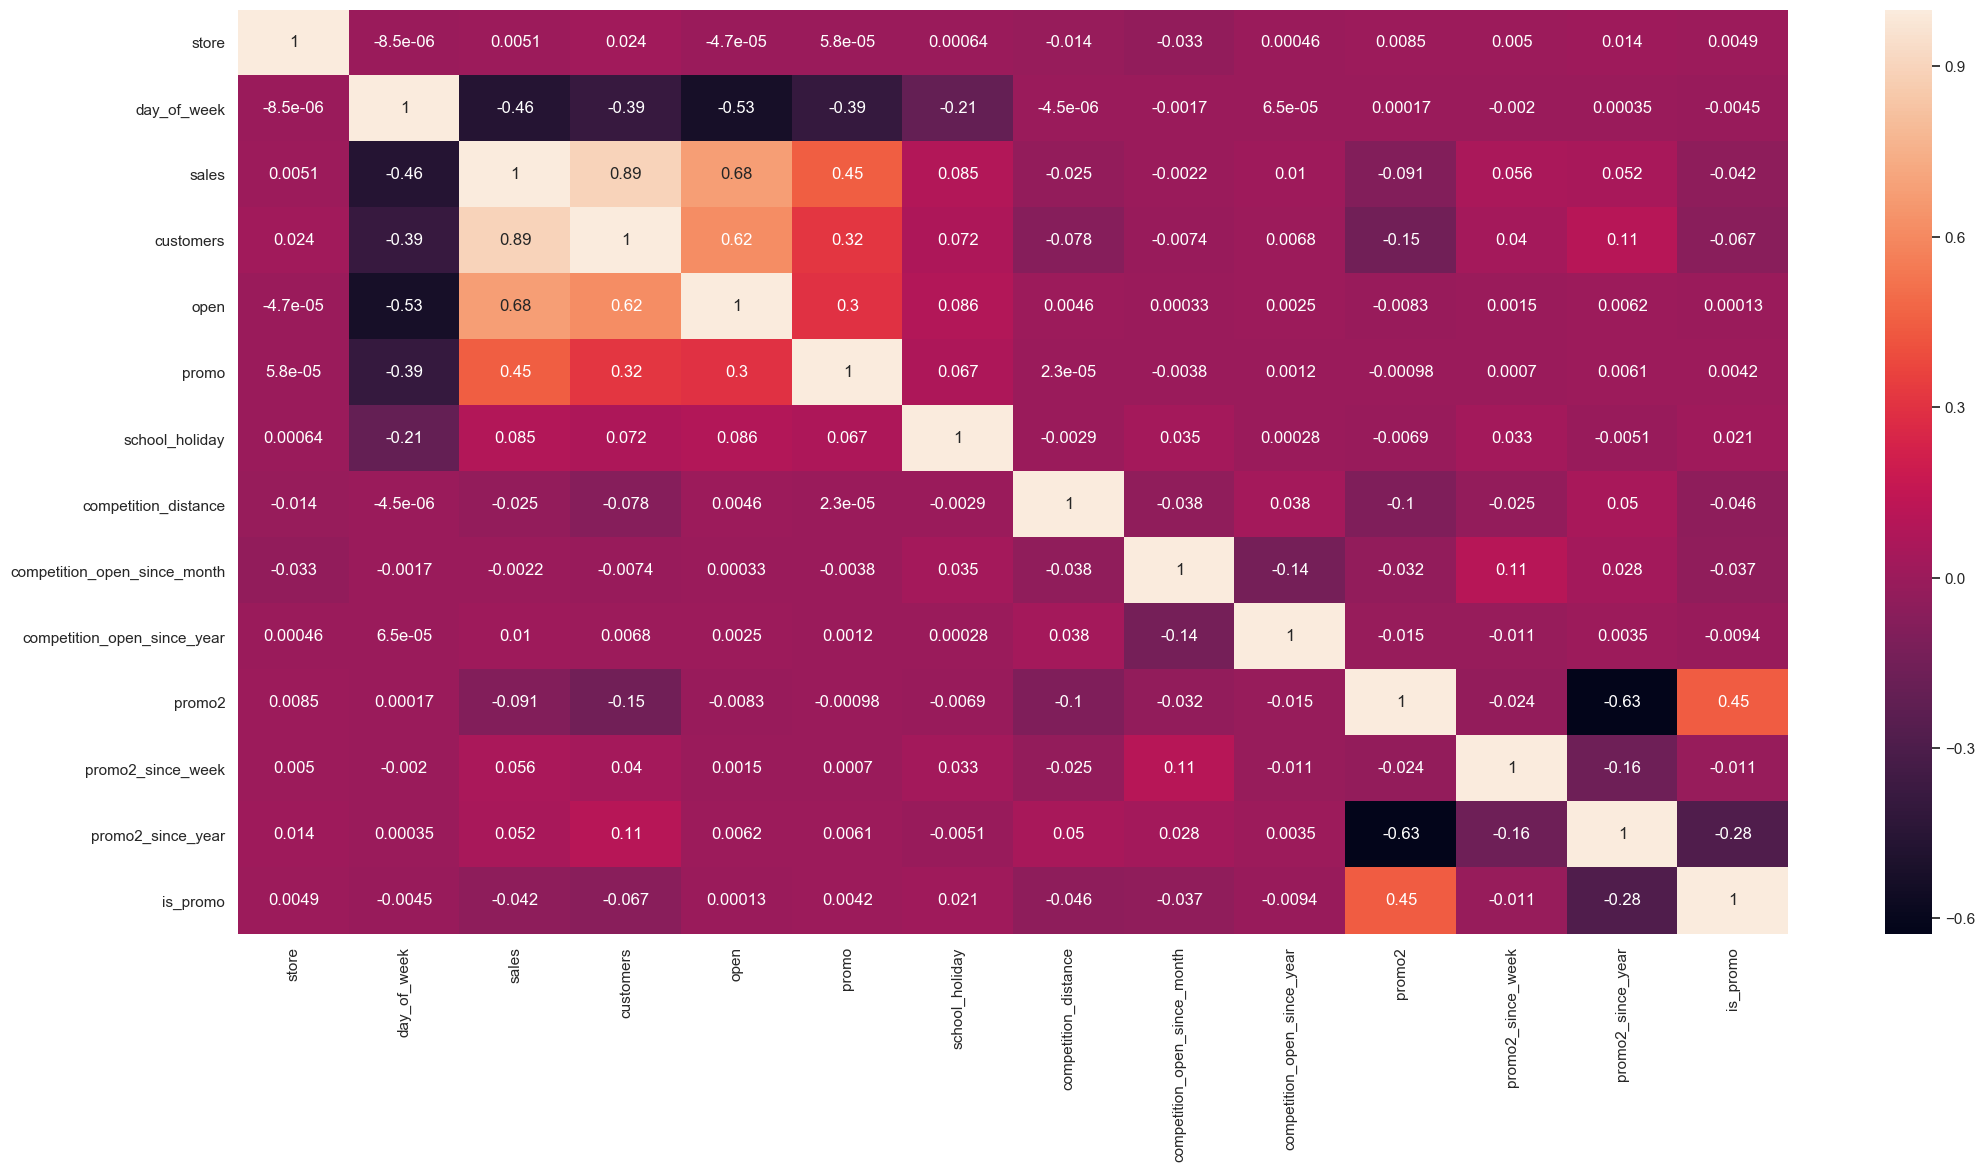

In [53]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical columns

In [54]:
# Selecting only categorical columns
cat_features = df4.select_dtypes(include= 'object')

# Calculate cramer V for every combination of cat variables
a1 = cramerv(cat_features['state_holiday'], cat_features['state_holiday'])
a2 = cramerv(cat_features['state_holiday'], cat_features['store_type'])
a3 = cramerv(cat_features['state_holiday'], cat_features['assortment'])

a4 = cramerv(cat_features['store_type'], cat_features['state_holiday'])
a5 = cramerv(cat_features['store_type'], cat_features['store_type'])
a6 = cramerv(cat_features['store_type'], cat_features['assortment'])

a7 = cramerv(cat_features['assortment'], cat_features['state_holiday'])
a8 = cramerv(cat_features['assortment'], cat_features['store_type'])
a9 = cramerv(cat_features['assortment'], cat_features['assortment'])

# Final dataset
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)


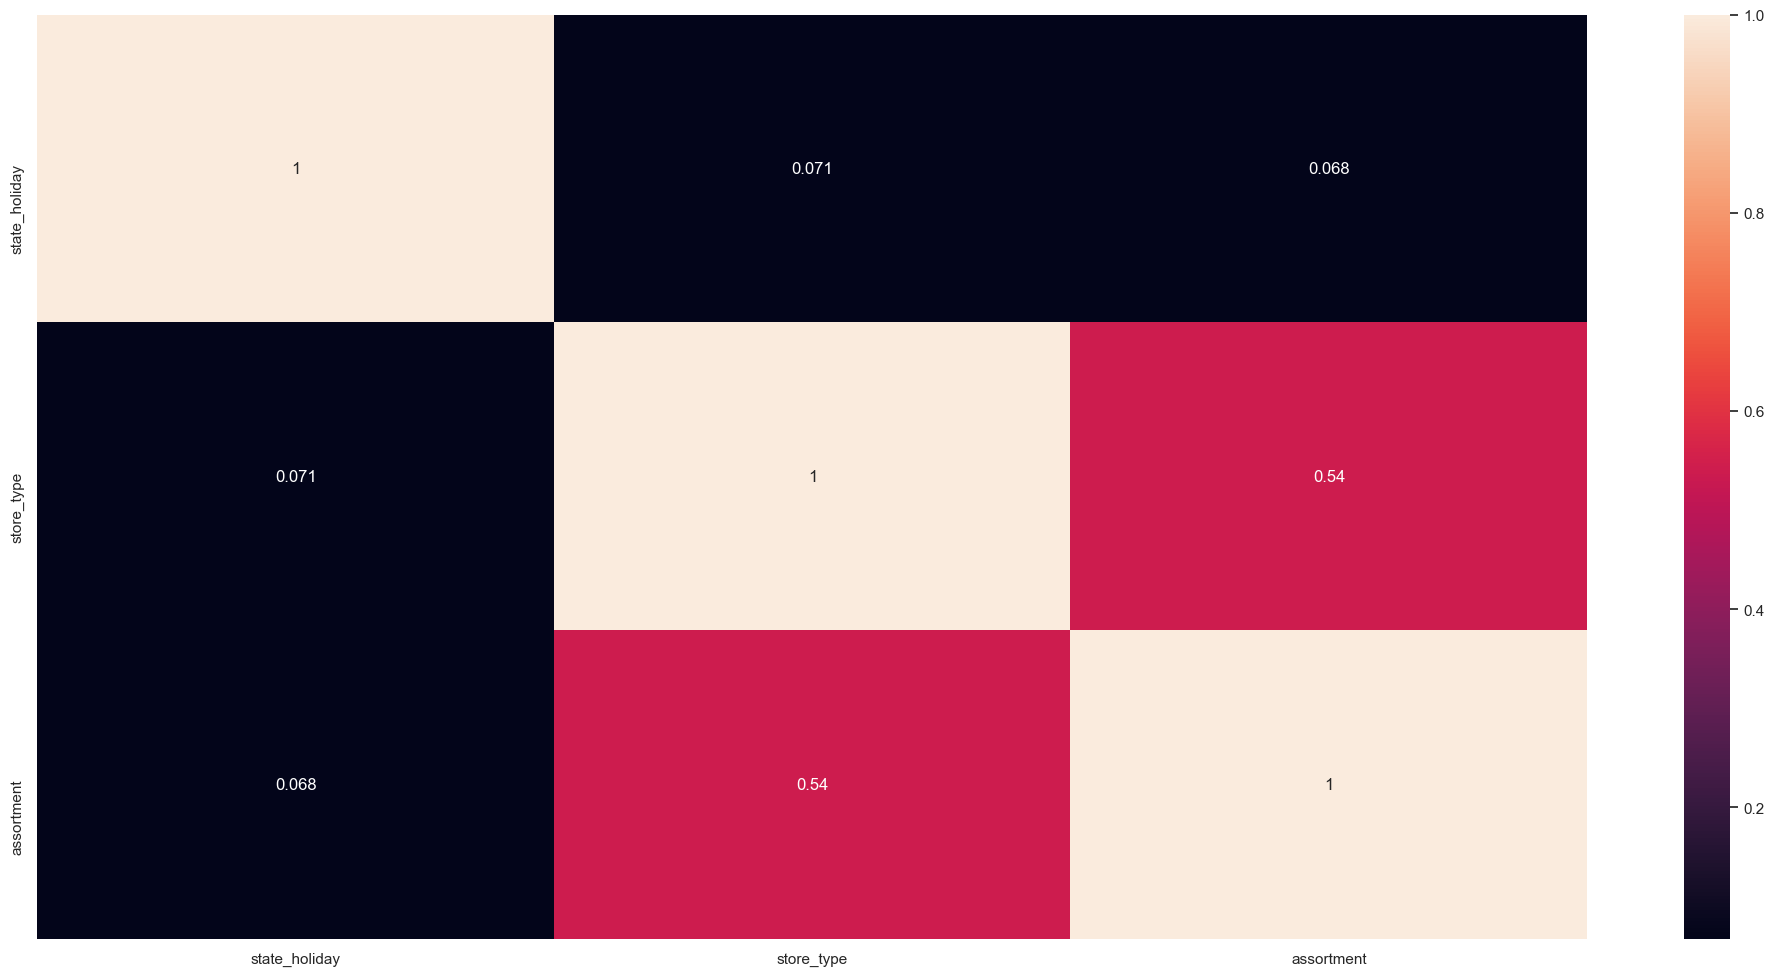

In [55]:
sns.heatmap(d, annot=True);

# 5.0 Data preparation

In [56]:
df5 = df4.copy()

## 5.1 Normalization

Looking into our numerical variables histograms we saw that none of them had a normal distribution, so we can skip this step, as applying normalization on data that do not origginally has some degree of normal distribution may impact the model performance.

## 5.2 Rescaling 

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month 
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [64]:
# state_holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix= ['state_holiday'], columns= ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal enconding (manual)
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

In [60]:
# month 
# day 
# week_of_year
# day_of_week